In [56]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
from copy import copy
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [58]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods_tags = {}
# fs_methods_tags = {
#     "lasso1_nocluster": "Lasso",
#     "pairwise-granger_nocluster": "Pairwise Granger",
#     "multivariate-granger_nocluster": "Multivariate Granger",
#     "dynotears_rollingcluster_k5": "Dynotears",
#     "var-lingam_rollingcluster_k5": "VAR-LiNGAM",

# }

fs_methods = [
    "sfstscv_nocluster", 
    "sfstscv_rollingkmeans_k5_pca",
    "dynotears_nocluster", 
    "dynotears_rollingkmeans_k5_pca",
    "pairwise-granger_nocluster",
    "pairwise-granger_rollingkmeans_k5_pca",
    "multivariate-granger_nocluster",
    "multivariate-granger_rollingkmeans_k5_pca",
    "var-lingam_rollingkmeans_k5_pca",
    ]

metric_names = ["mse", "mae", "rmse", "mse_crisis", "mae_crisis", "rmse_crisis"]
etf_focus = None
stability_threshold = 0.8   
plot_ts = False

In [59]:
warnings.simplefilter("ignore")

all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']

        # filter predictions
        predictions_df.loc[(predictions_df['prediction_zscore'] == 1)|(predictions_df['prediction_zscore'] == -1), 'prediction_zscore'] = 0
        predictions_df.loc[(predictions_df['prediction'] == 1)|(predictions_df['prediction'] == -1), 'prediction'] = 0

        predictions_gfc_df = predictions_df.loc["2007-07-01":"2008-11-01"]
        predictions_dj_flash_crash_df = predictions_df.loc["2010-03-01":"2010-07-01"]
        predictions_tsunami_fukushima_df = predictions_df.loc["2011-01-01":"2011-05-01"]
        predictions_black_monday_df = predictions_df.loc["2011-06-01":"2011-10-01"]
        predictions_chinese_black_monday_df = predictions_df.loc["2015-06-01":"2015-10-01"]
        predictions_dj_plunge_df = predictions_df.loc["2018-01-01":"2018-05-01"]
        predictions_covid_df = predictions_df.loc["2020-01-01":"2020-05-01"]

        crisis_predictions = [
            predictions_gfc_df, predictions_dj_flash_crash_df, predictions_tsunami_fukushima_df, 
            predictions_black_monday_df, predictions_chinese_black_monday_df, predictions_dj_plunge_df, predictions_covid_df
            ]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = ((rolling_metric_df["true"]  - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean()
        rolling_metric_df["rolling_mae"] = (abs(rolling_metric_df["true"] - rolling_metric_df["prediction"])).rolling(window=12).mean()
        rolling_metric_df["rolling_rmse"] = np.sqrt(((rolling_metric_df["true"] - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean())
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_mae", "rolling_rmse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100
        rmse = np.sqrt(mean_squared_error(predictions_df["true"], predictions_df["prediction"])) * 100

        crisis_predictions_df = pd.concat(crisis_predictions)
        crisis_mse = mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_mae = mean_absolute_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_rmse = np.sqrt(mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"])) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # add tags
        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        # fill na of clusters column
        if "nocluster" in fs:
            parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
        elif ("pca" in fs):
            codes, uniques = pd.factorize(parents_of_target_df['fred'])
            parents_of_target_df['cluster'] = codes         
        else:
            parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

        all_parents.append(parents_of_target_df)

        metrics_df = pd.DataFrame({
            "fs": fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            "rmse": [rmse],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "rmse_crisis": [crisis_rmse]})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

In [60]:
all_etfs_scores = []
all_avg_scores = []
for ticker in all_parents_df["etf"].unique():
    etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
    etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

    etf_df = etf_df.sort_values(by=["date"])
    all_scores = []
    for fs in etf_df["fs"].unique():
        fs_etf_df = etf_df[etf_df["fs"] == fs]

        score = []
        for i, date in enumerate(fs_etf_df["date"].unique()):
            if i == 0:
                F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = 0
            else:
                F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
                F_tm1 = copy(F_t)
            score.append({"date": date, "score": s})
        score_df = pd.DataFrame(score)
        score_df["fs"] = fs

        melt_score_df = score_df.melt(["date", "fs"])
        all_scores.append(melt_score_df)
    all_scores_df = pd.concat(all_scores).drop("variable", axis=1)
    all_scores_df["etf"] = ticker
    all_etfs_scores.append(all_scores_df)

    avg_scores = all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False).reset_index()
    avg_scores['ticker'] = ticker
    avg_scores = avg_scores[['ticker', 'fs', 'value']]
    all_avg_scores.append(avg_scores)
all_avg_scores_df = pd.concat(all_avg_scores)
all_etfs_scores_df = pd.concat(all_etfs_scores)

## Boxplots with summary statistics

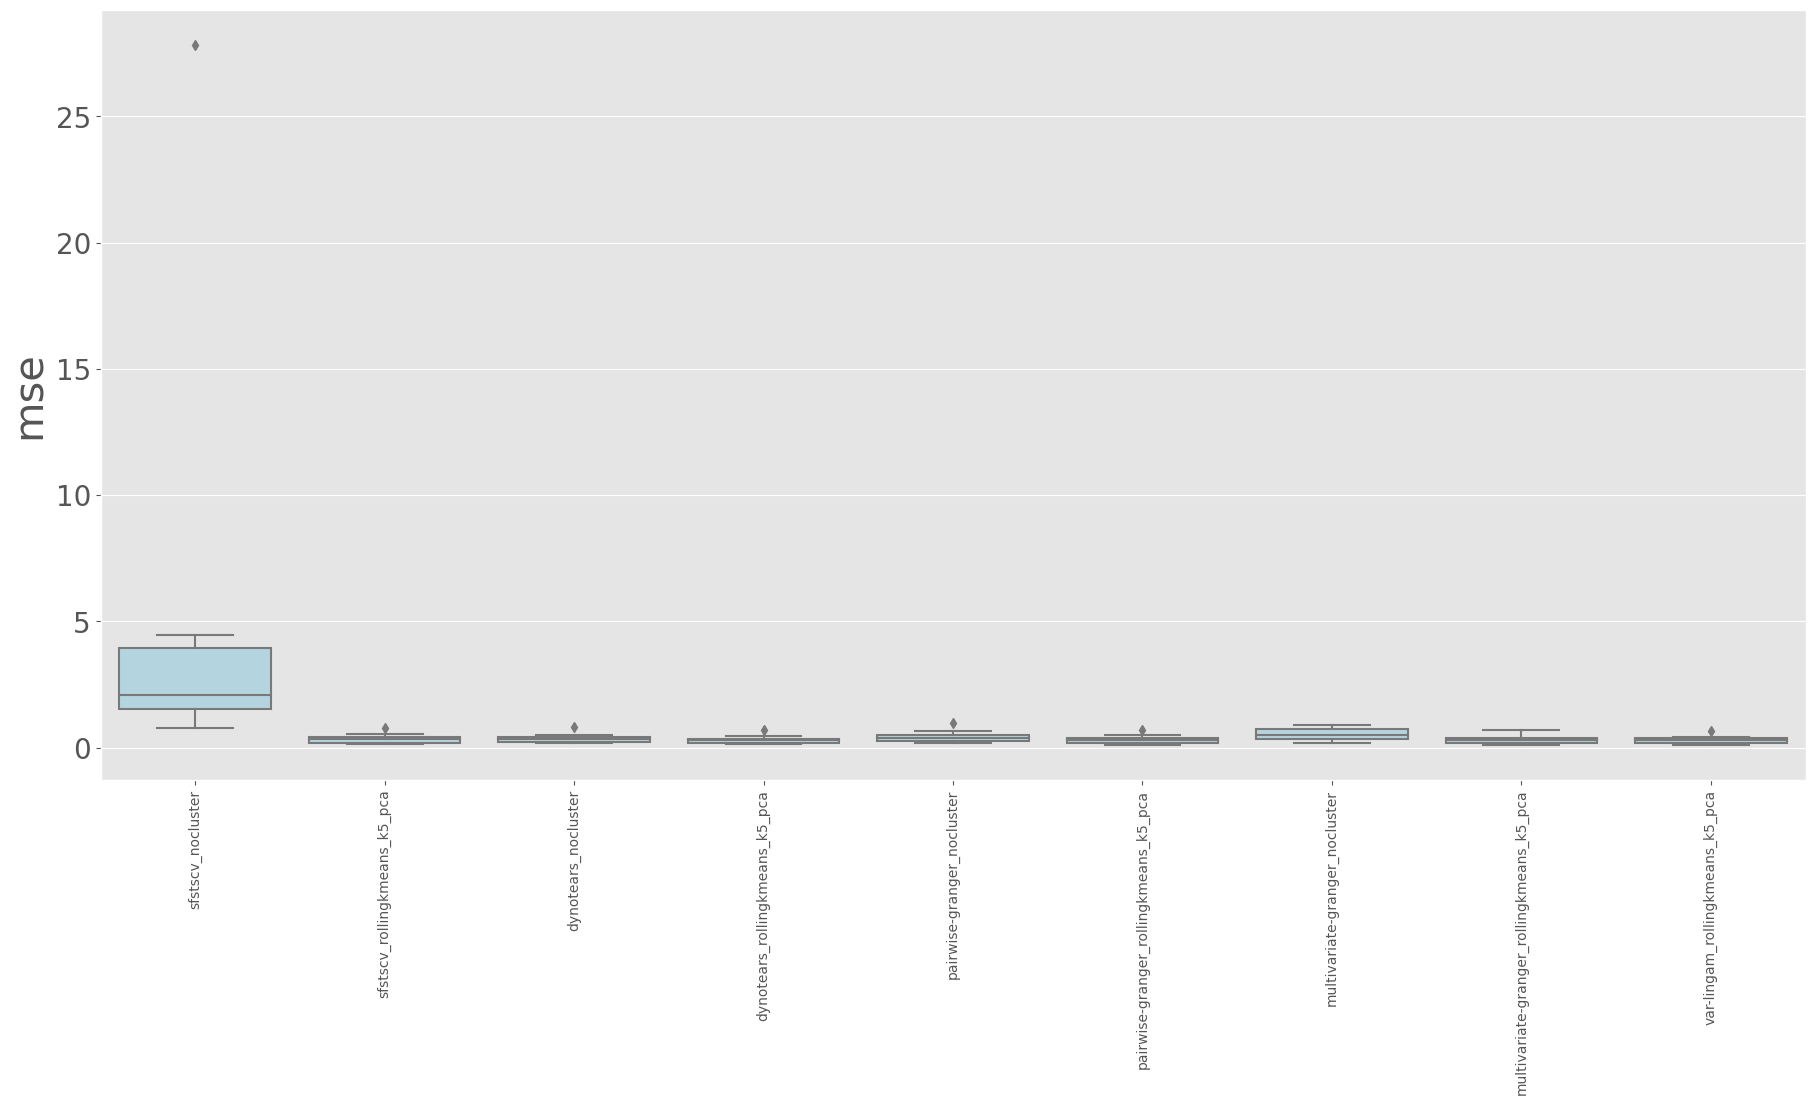

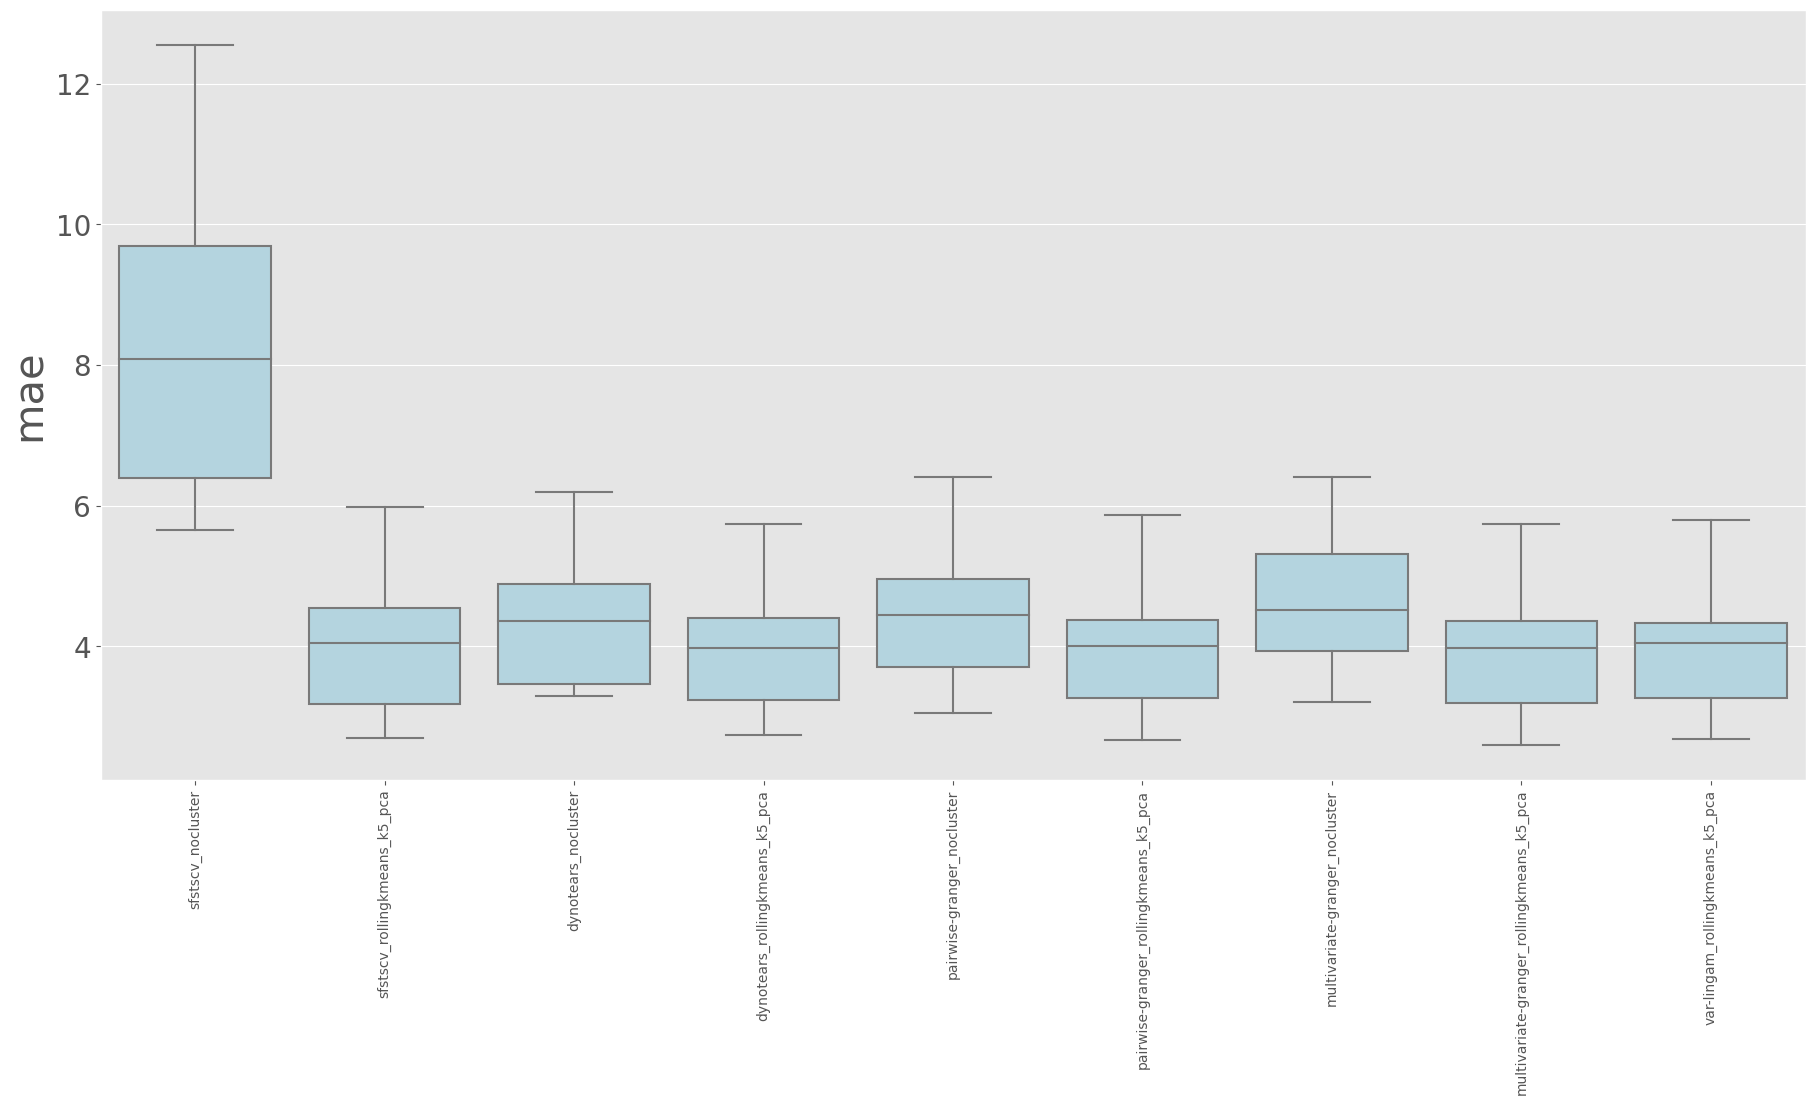

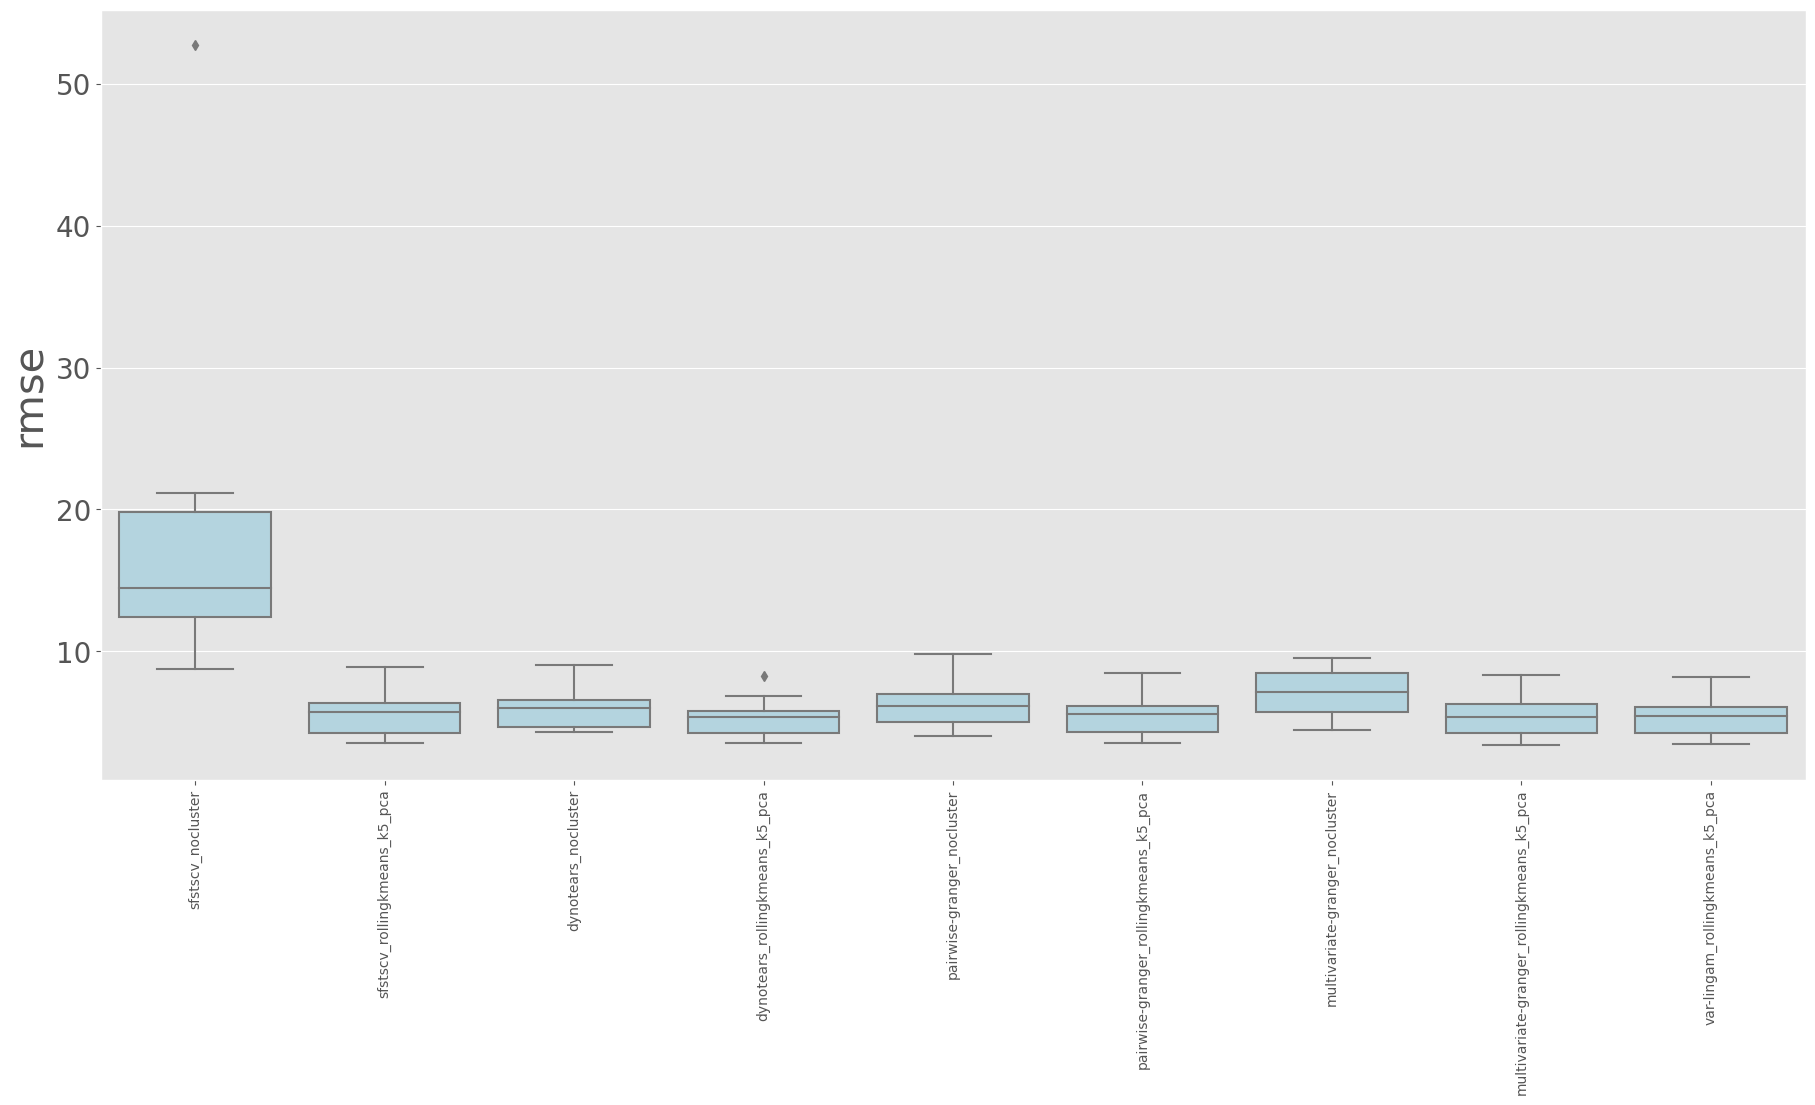

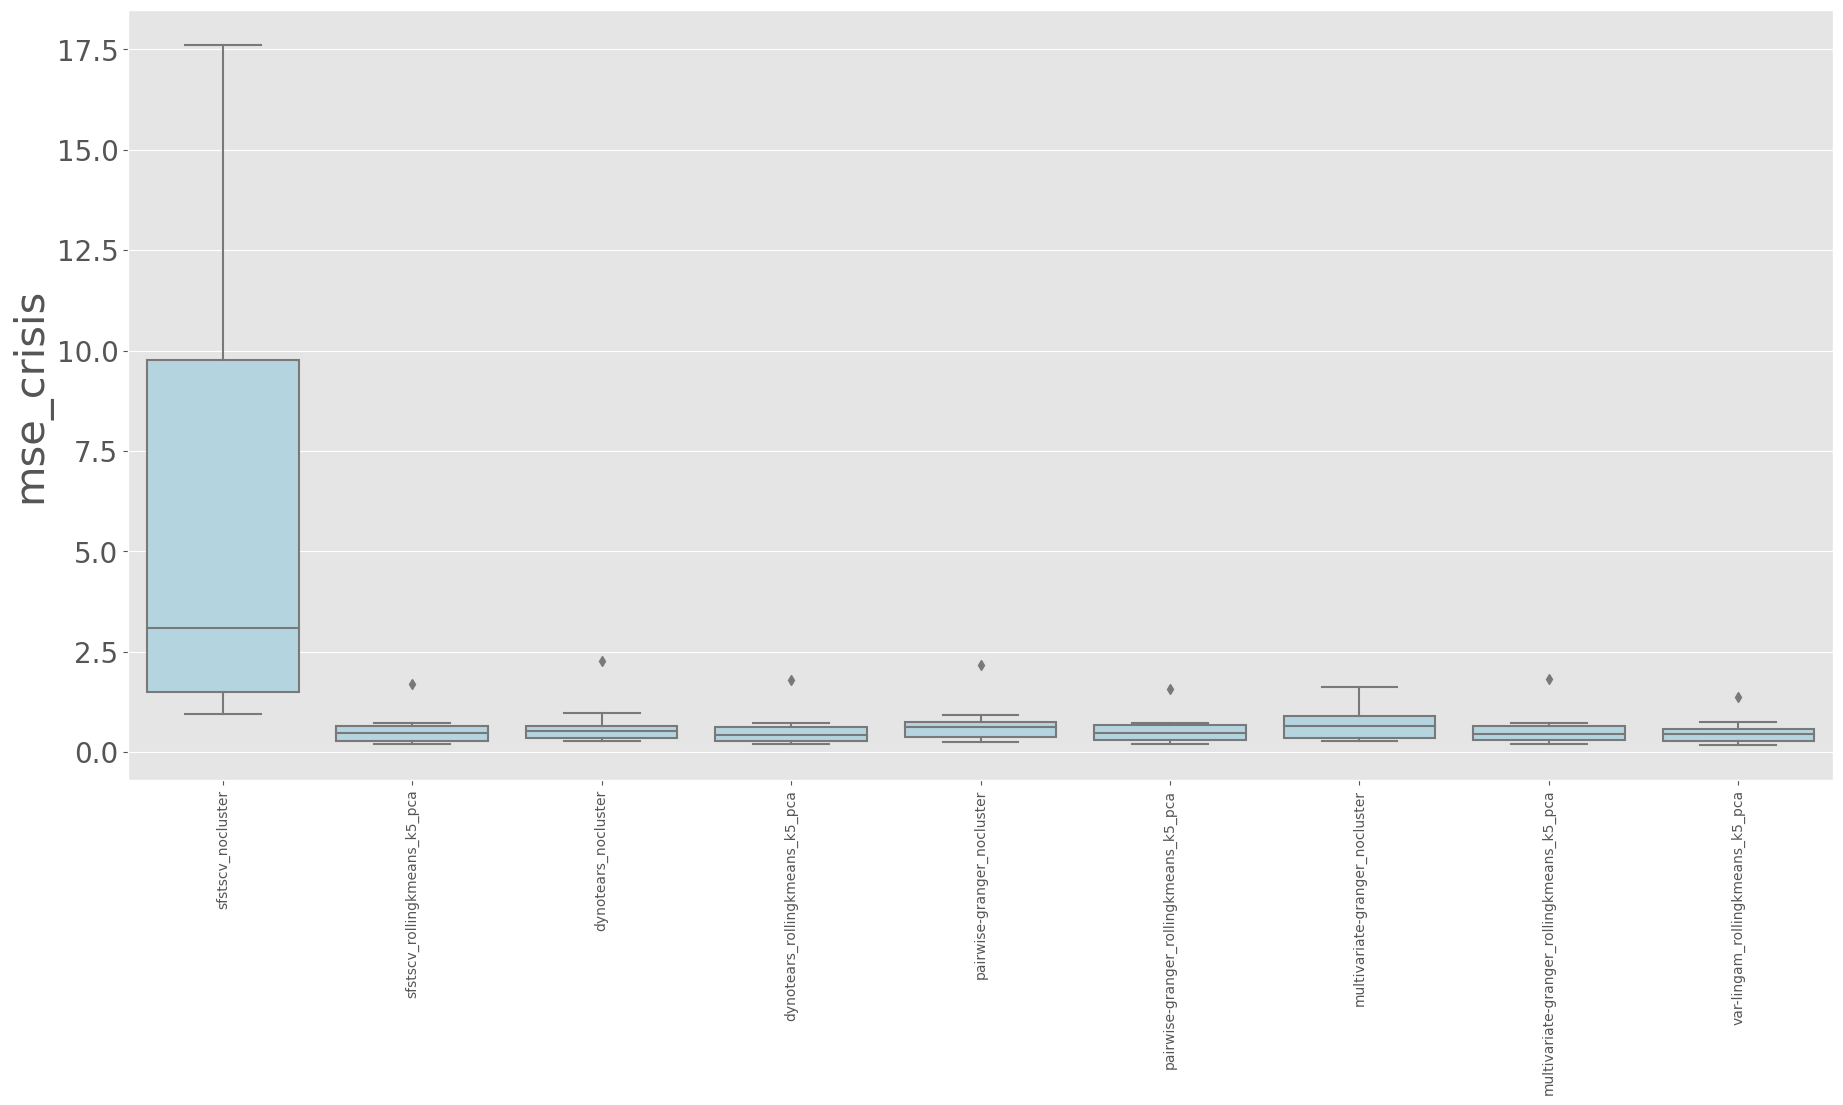

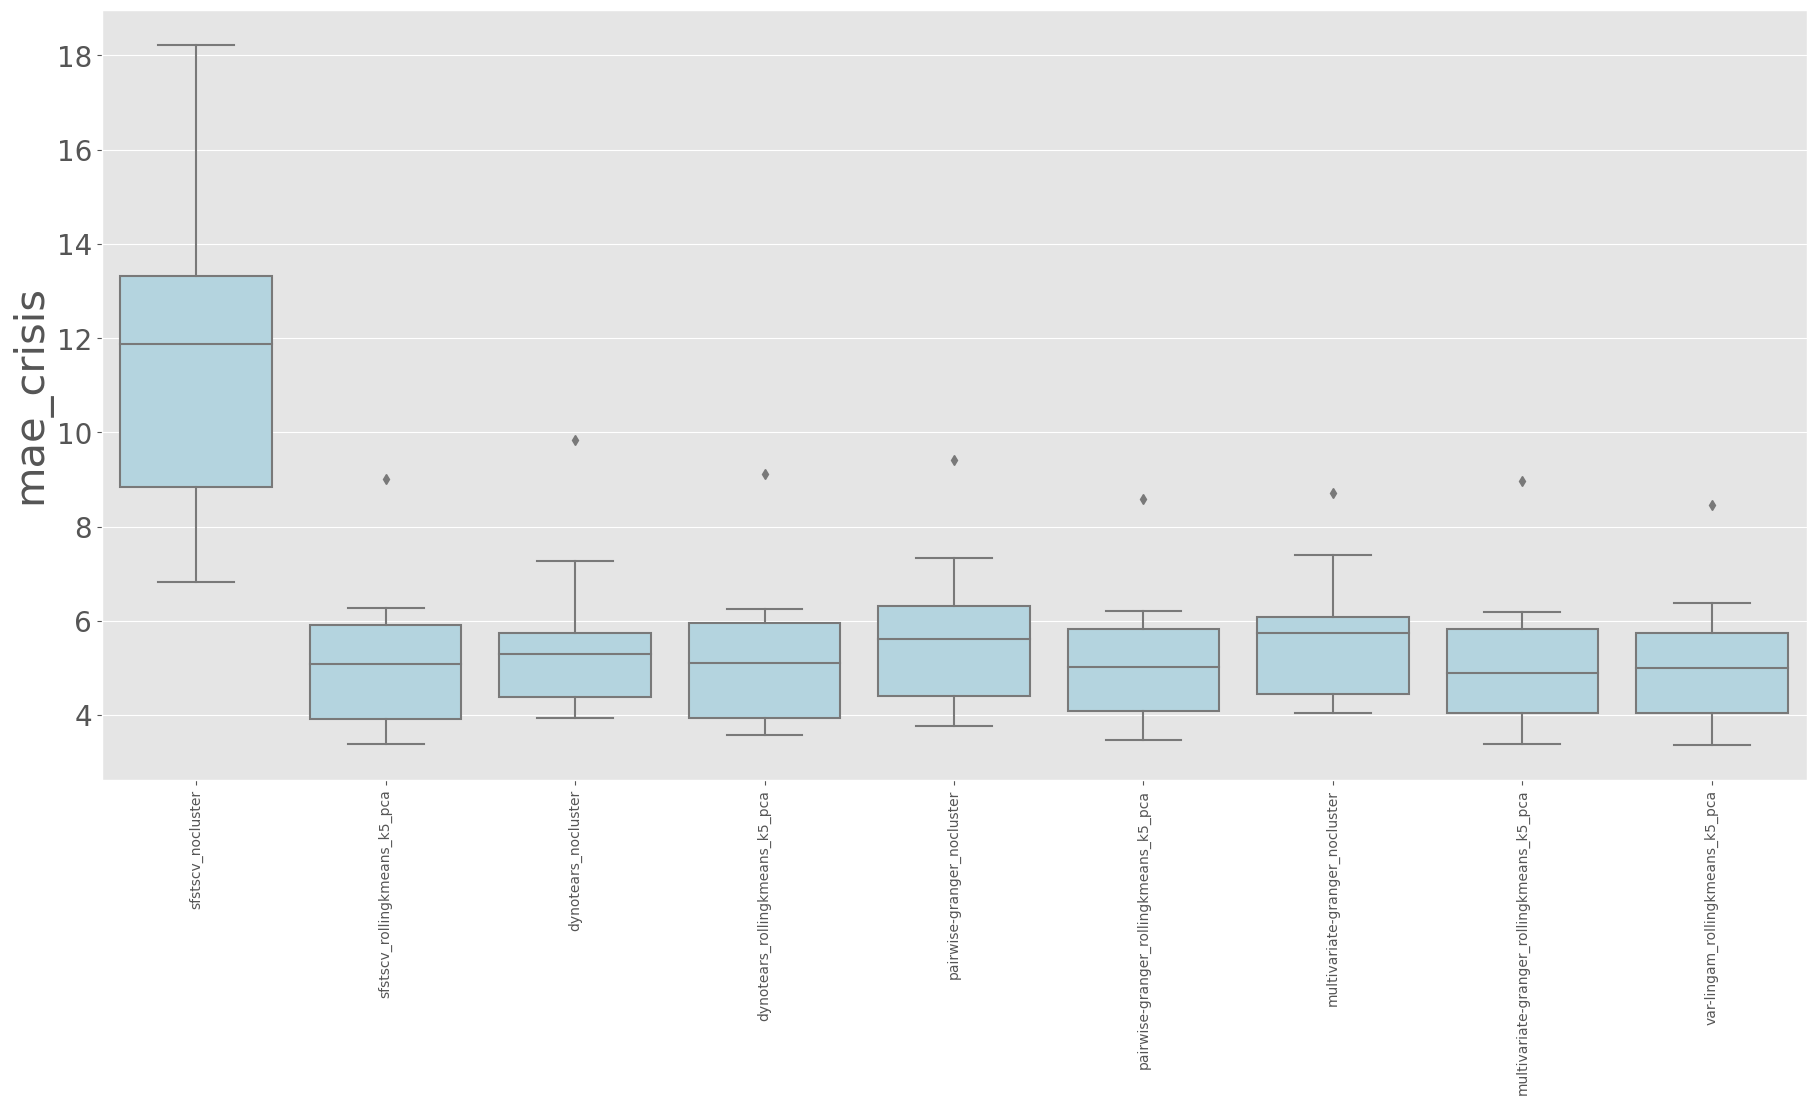

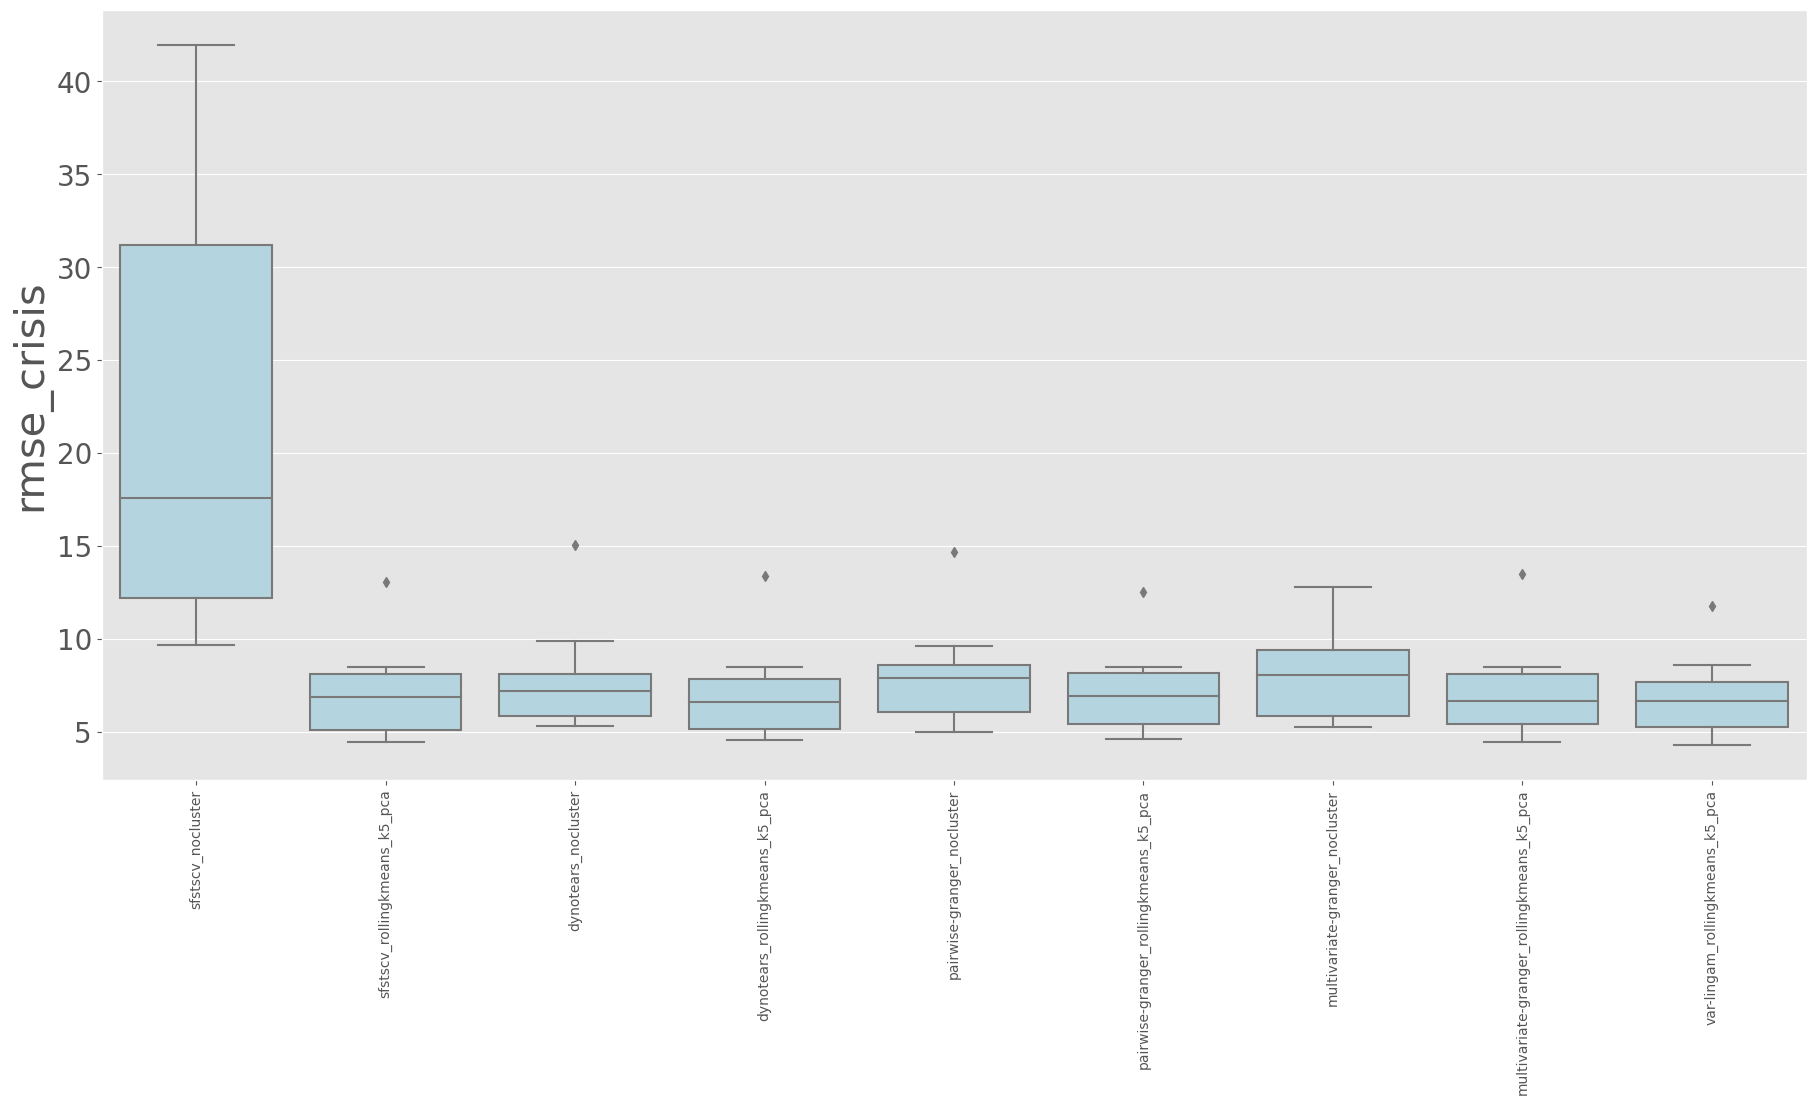

In [61]:
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=10)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_fs.png'))

## Prediction error over time

### (a) Rolling MSE

In [62]:
# etf = "XLI"
# selected_models = [
#     "sfstscv_nocluster",
#     "dynotears_nocluster",
#     "pairwise-granger_nocluster",
#     "multivariate-granger_nocluster",
# ]

# etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
# etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()

# etf_rolling_metrics_df.reset_index().to_csv(os.path.join(results_path, f"{etf}_rolling_mse.csv"), index=False)

# etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mae")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
# etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()

# etf_rolling_metrics_df.reset_index().to_csv(os.path.join(results_path, f"{etf}_rolling_mae.csv"), index=False)

# etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
# etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()

# etf_rolling_metrics_df.reset_index().to_csv(os.path.join(results_path, f"{etf}_rolling_rmse.csv"), index=False)

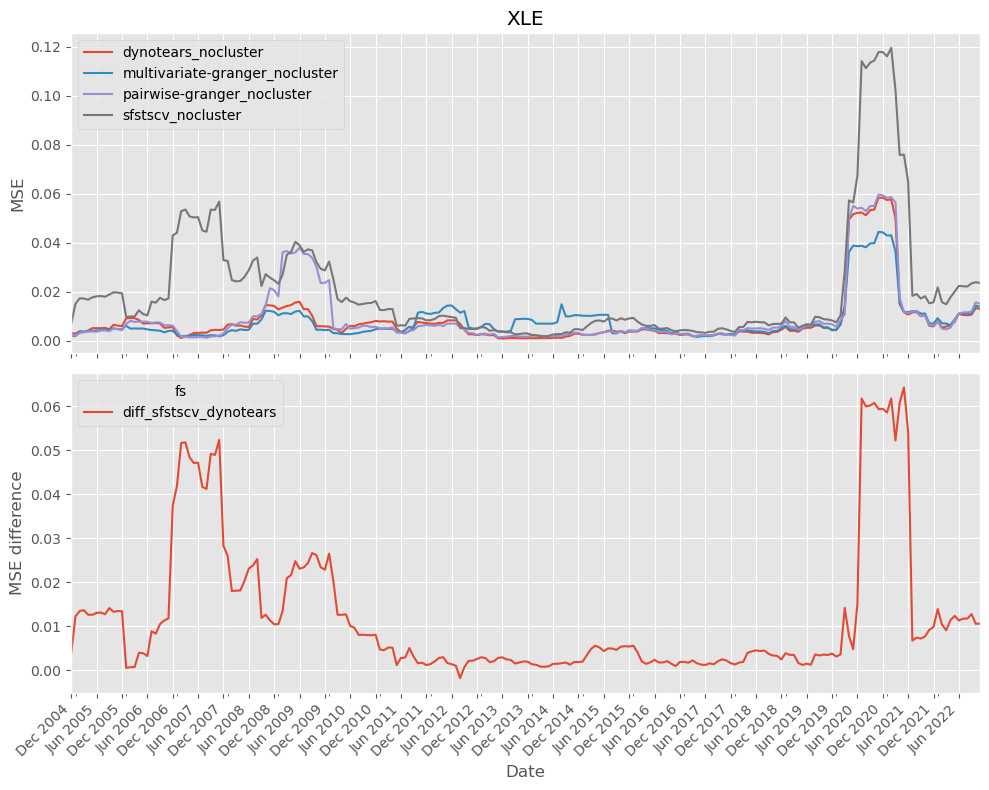

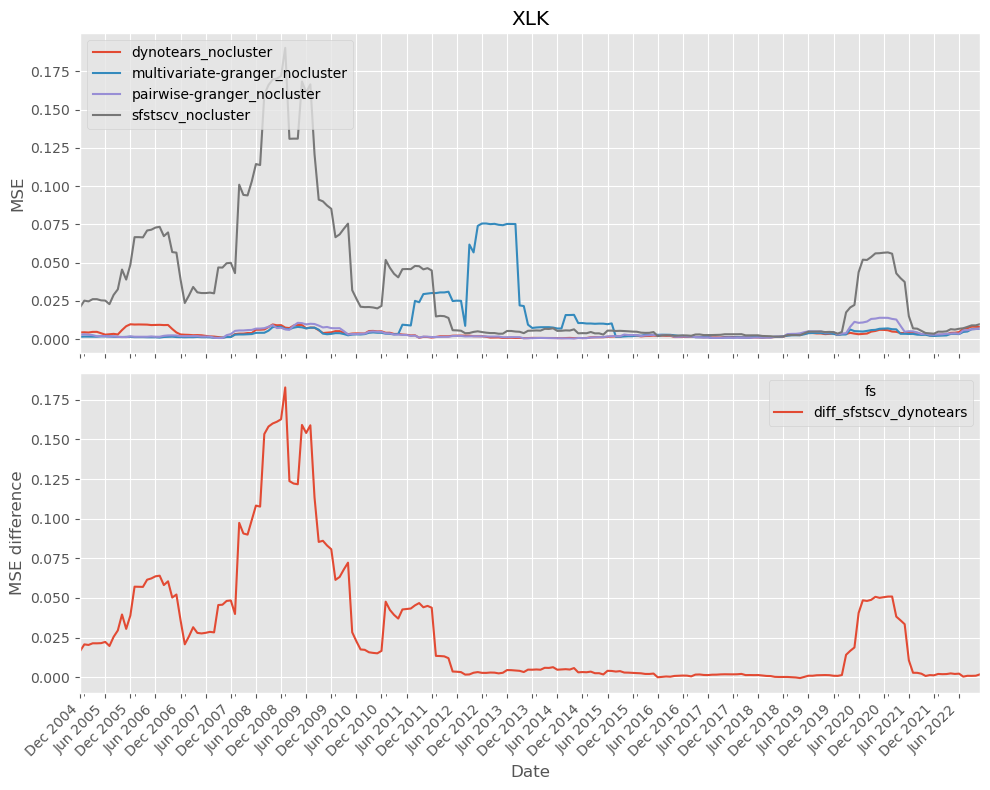

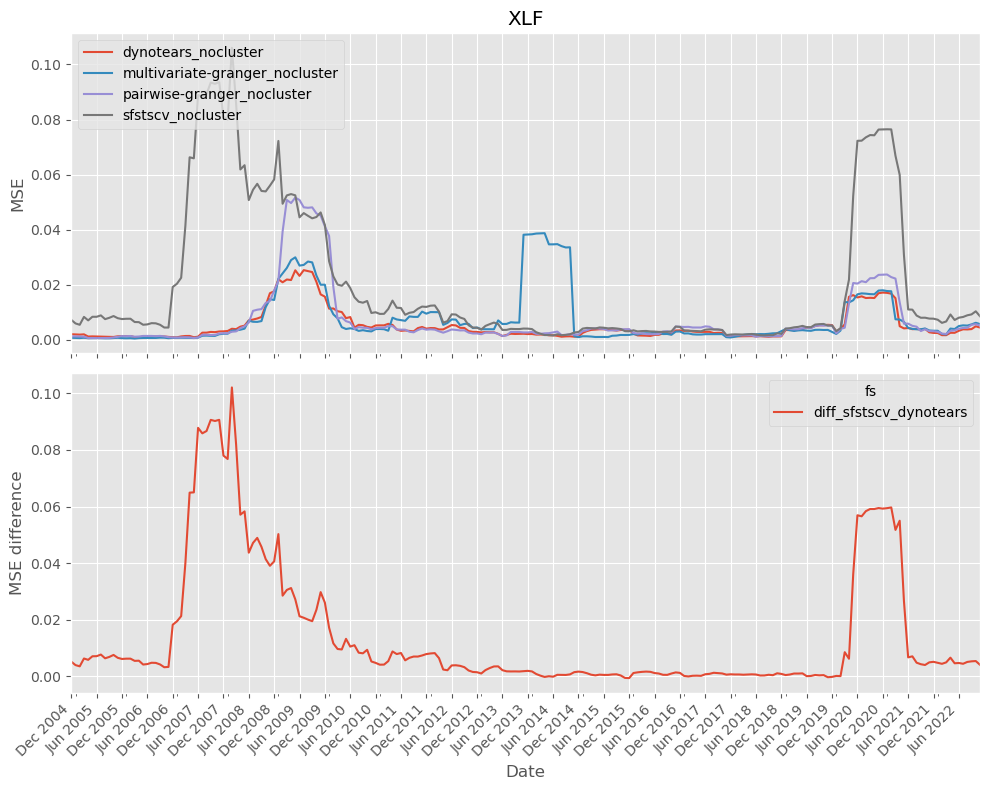

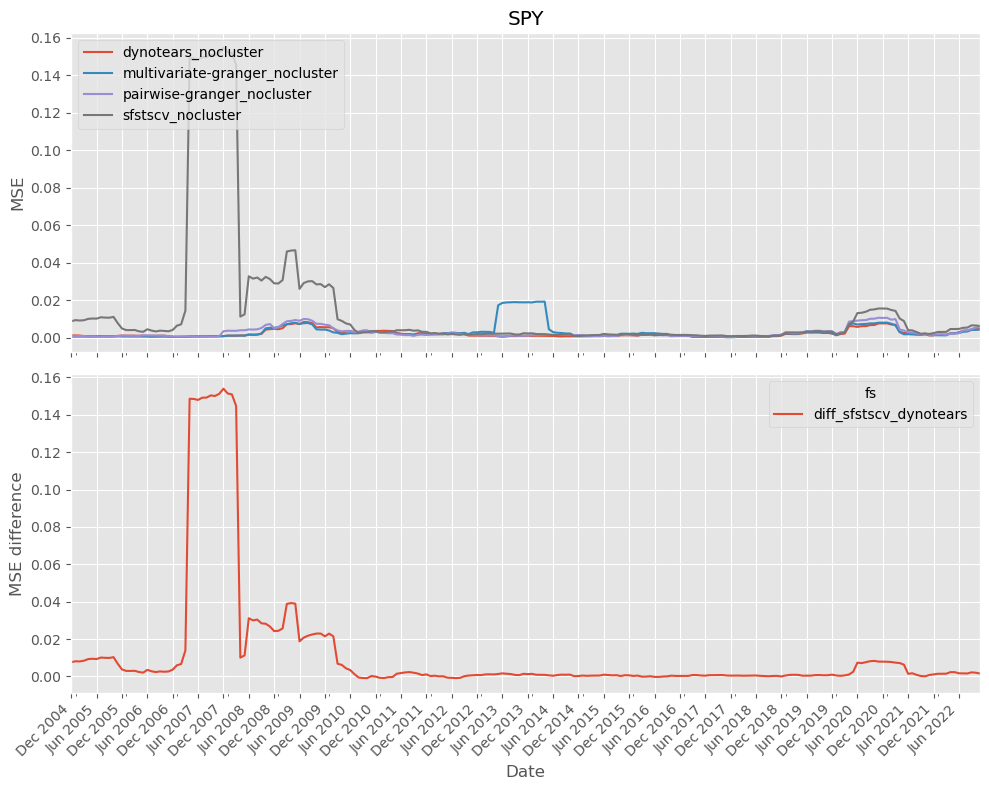

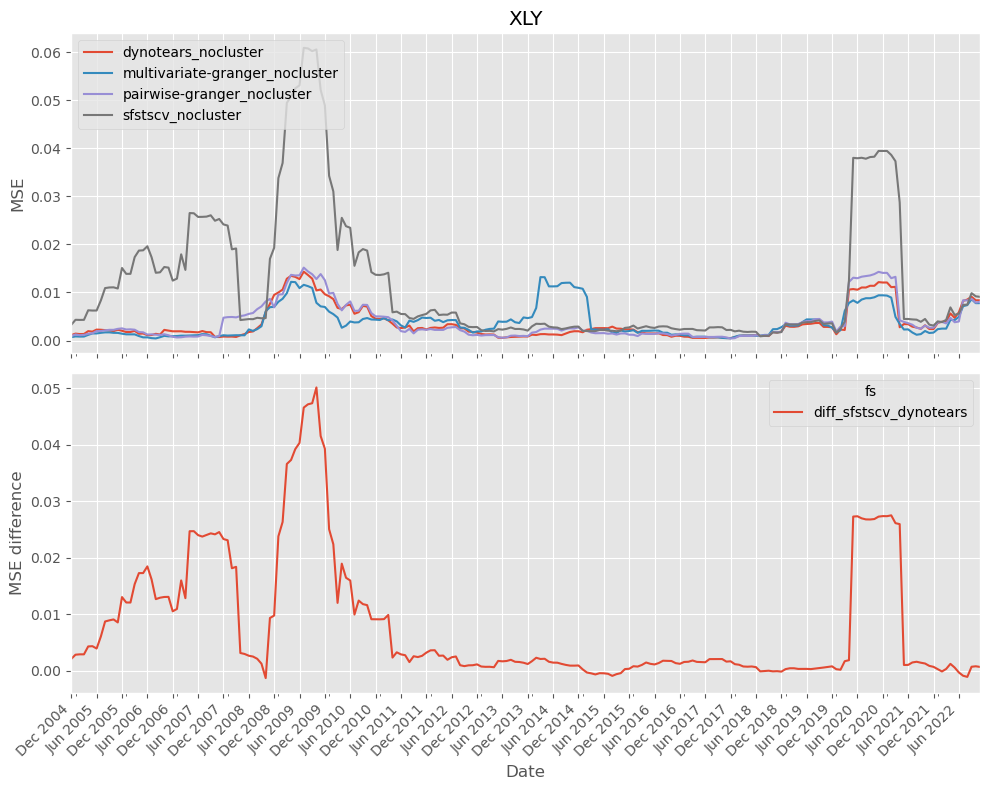

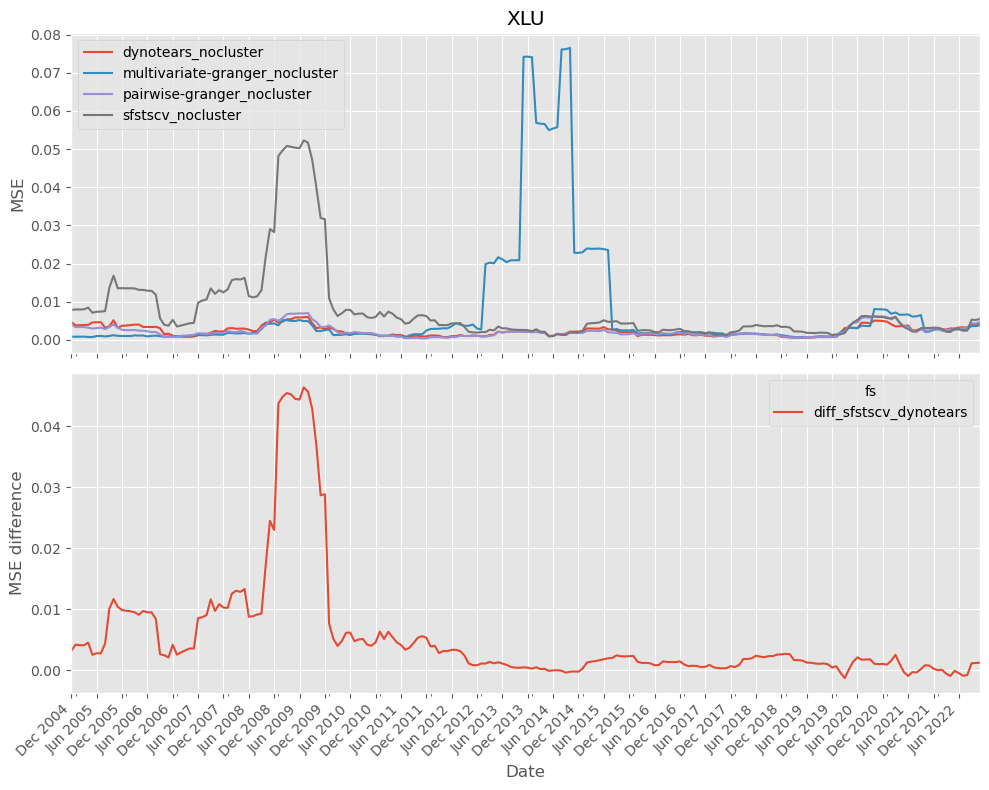

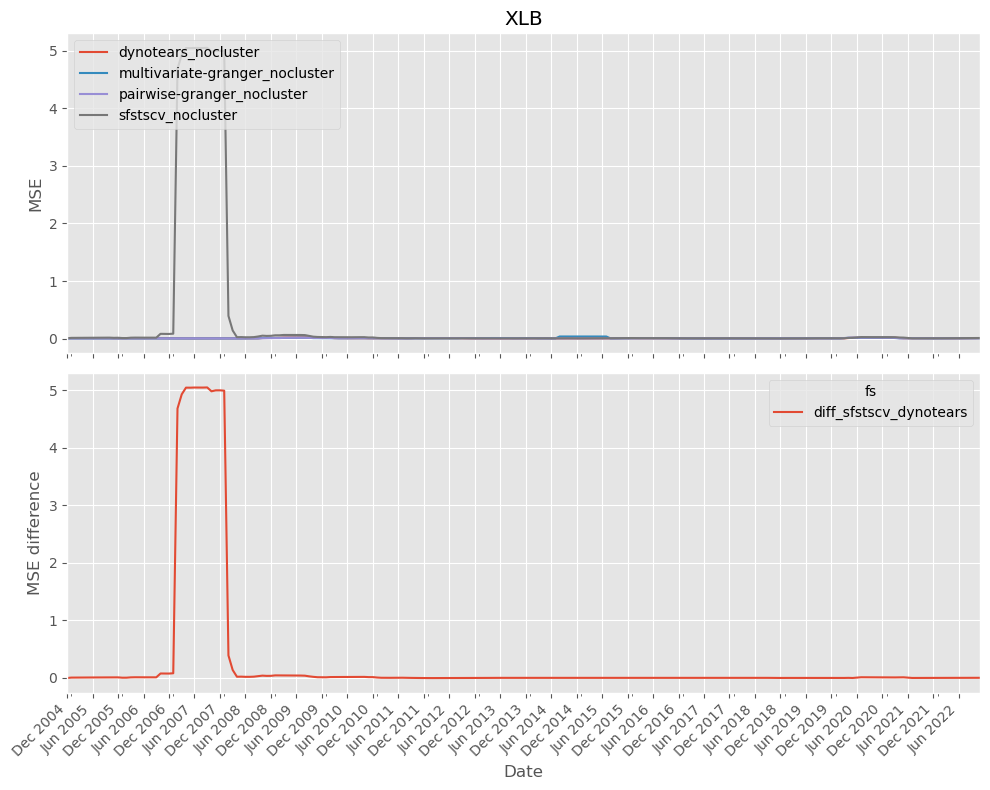

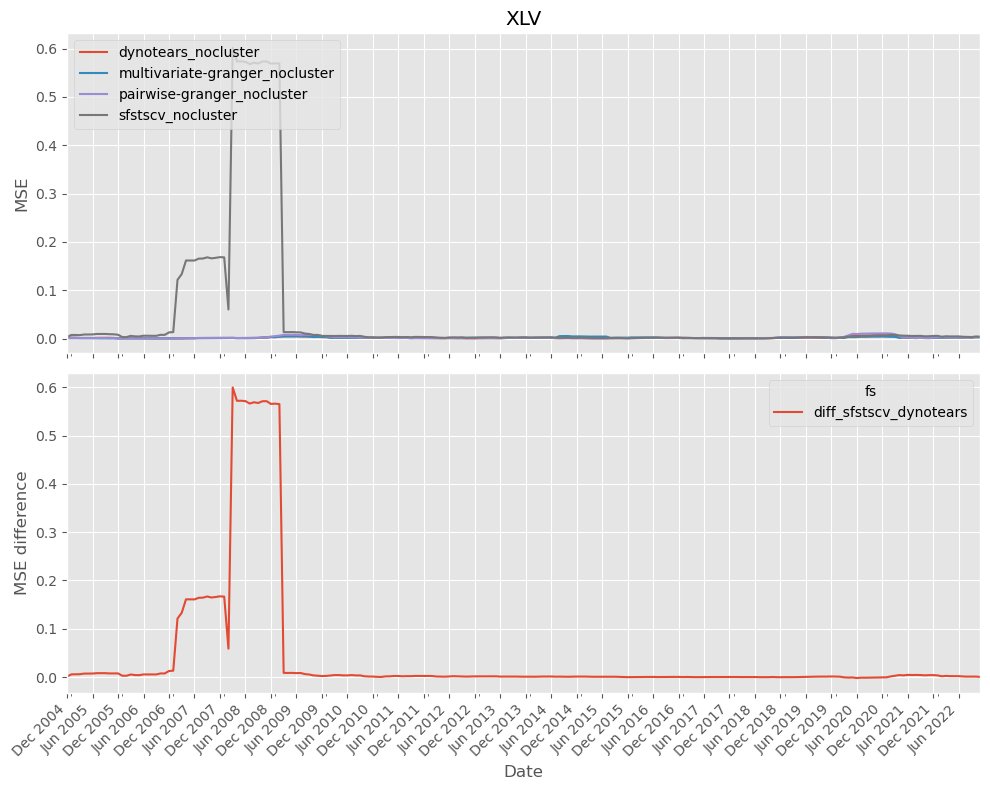

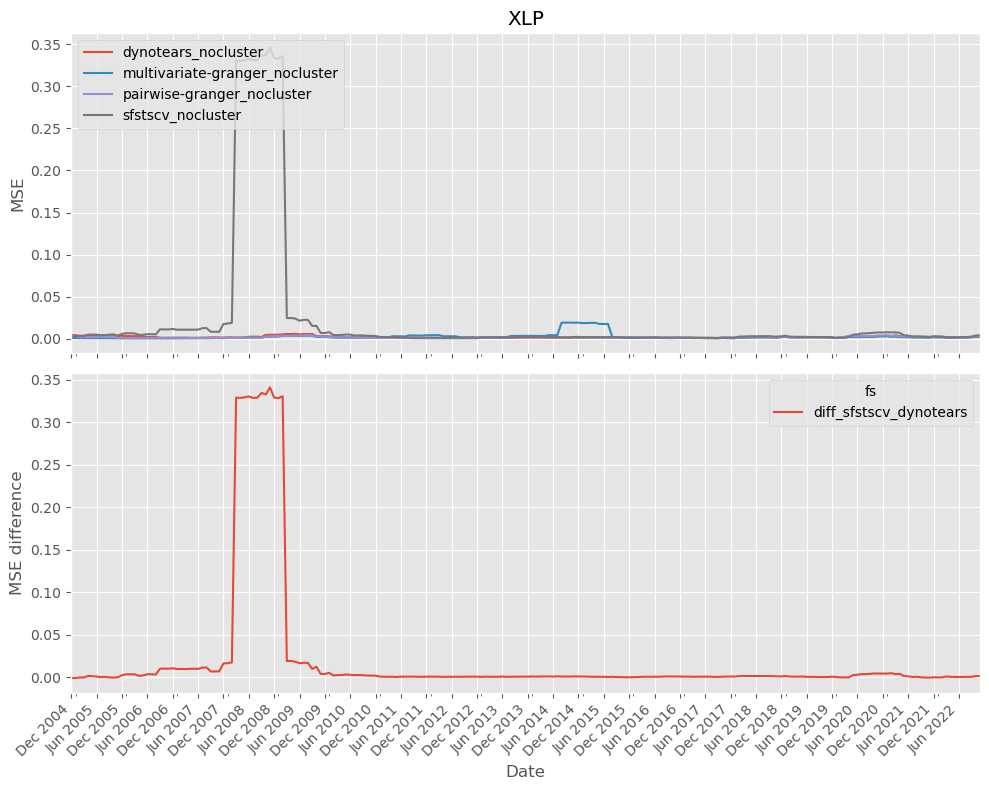

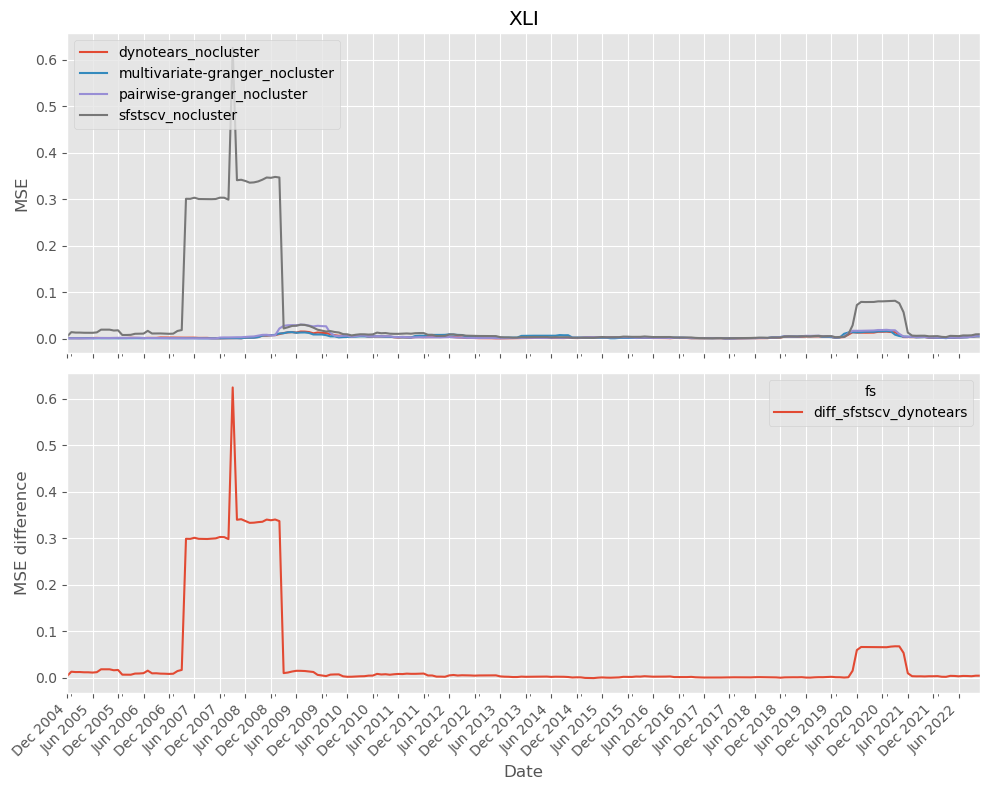

In [63]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
]

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_sfstscv_dynotears"] = etf_rolling_metrics_df["sfstscv_nocluster"] - etf_rolling_metrics_df["dynotears_nocluster"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_sfstscv_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_sfstscv_dynotears"]].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mse.png'))

    # Show the plot
    plt.show()

### (b) Rolling RMSE

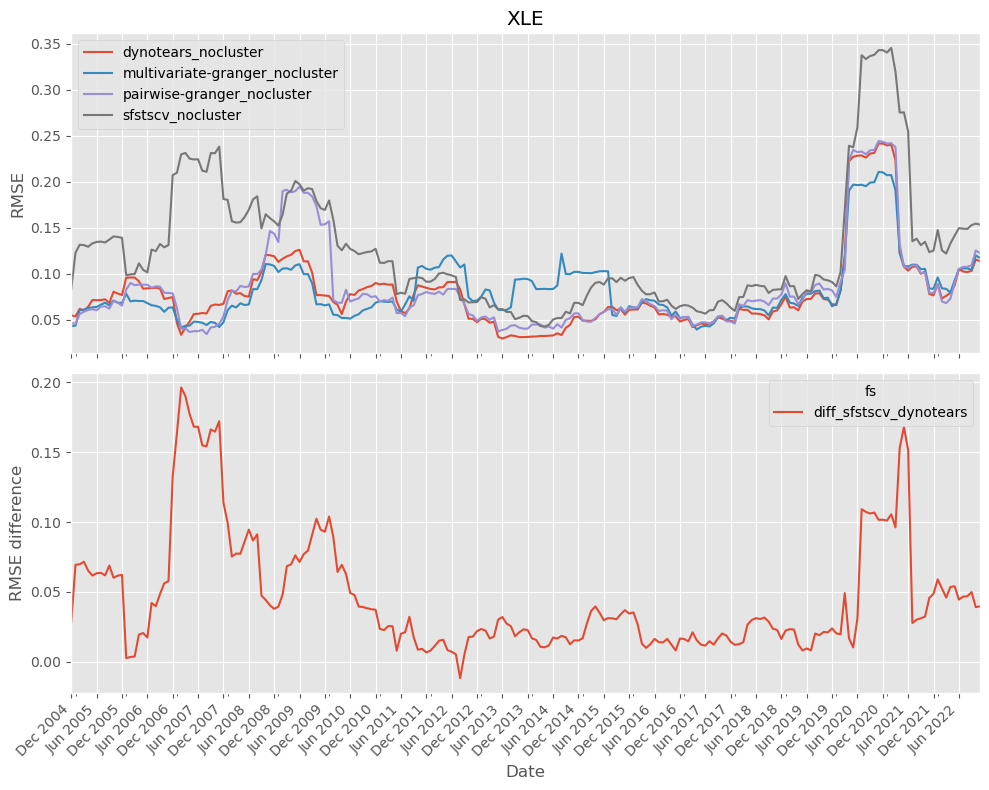

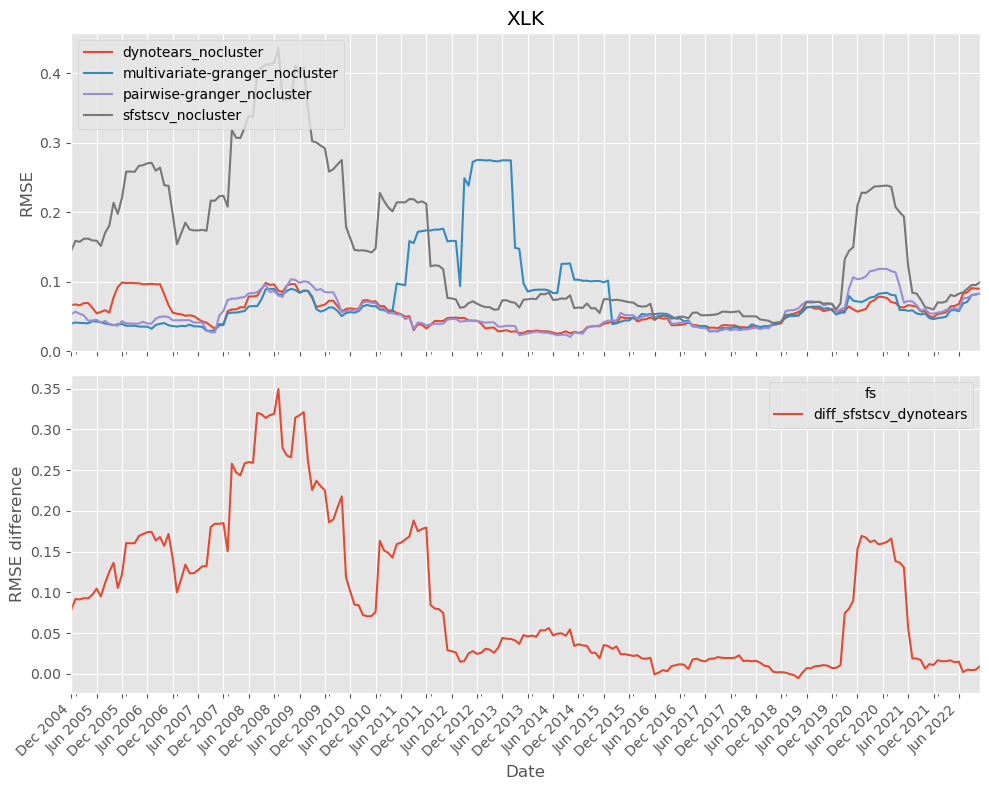

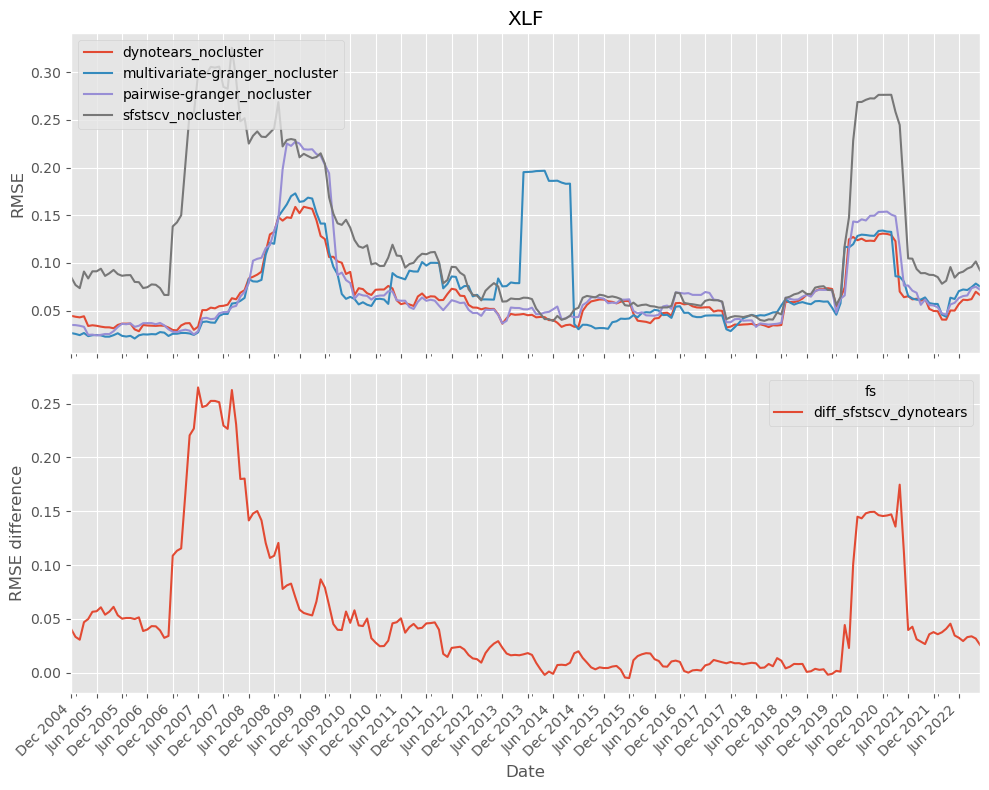

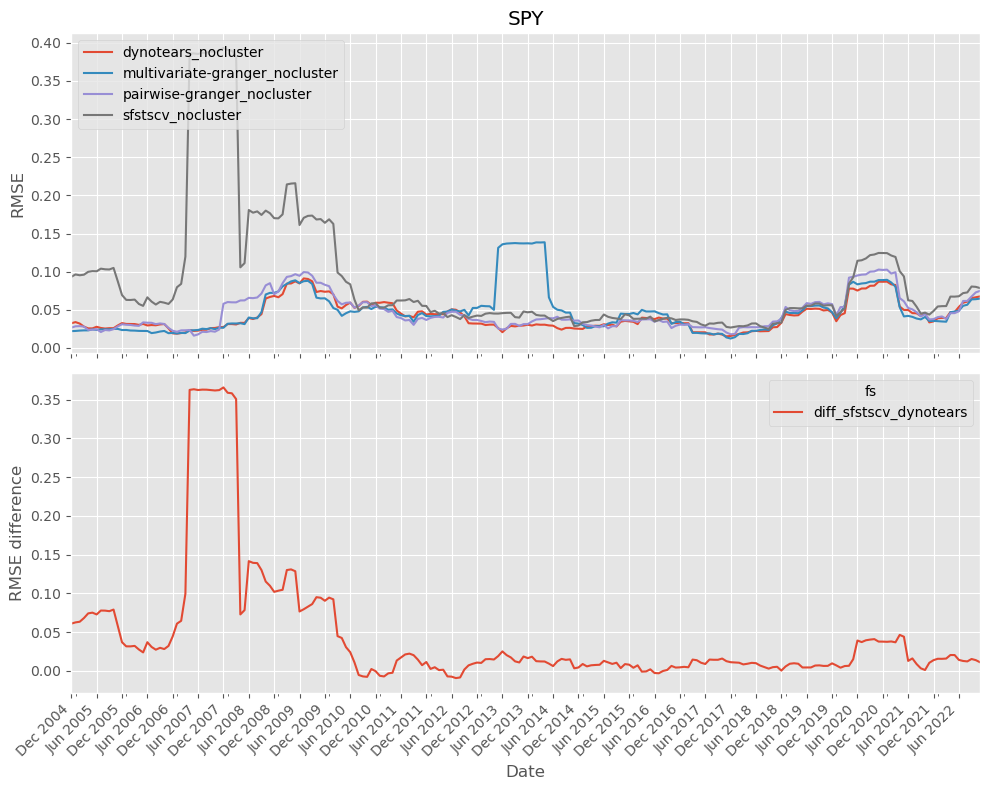

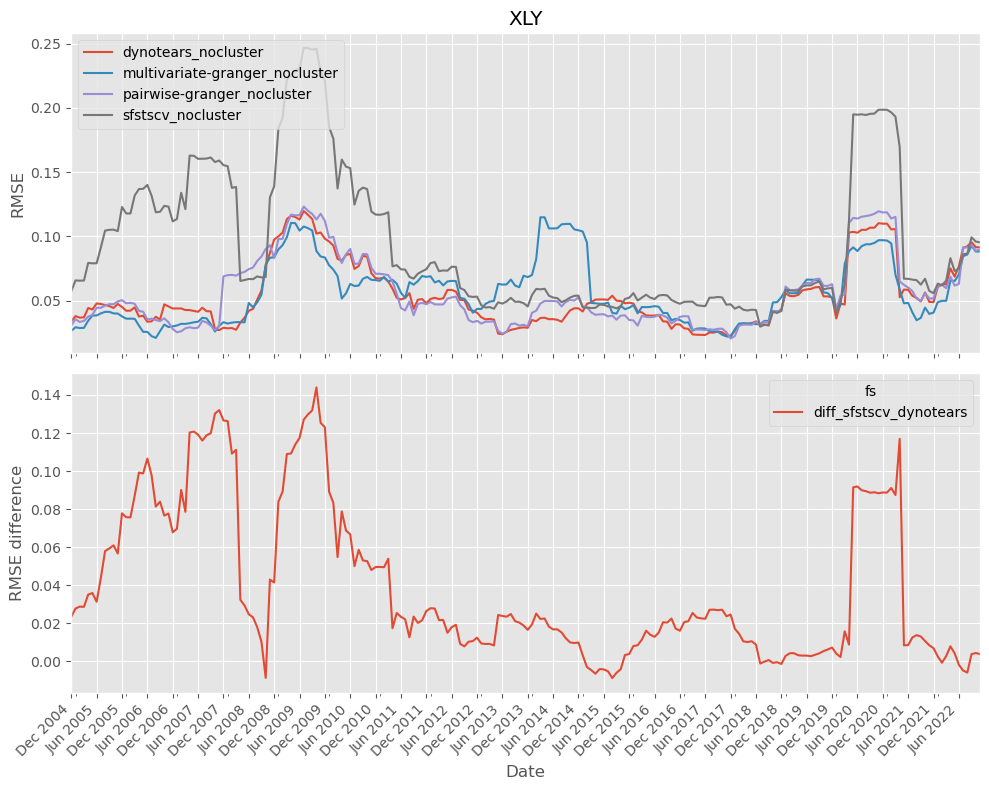

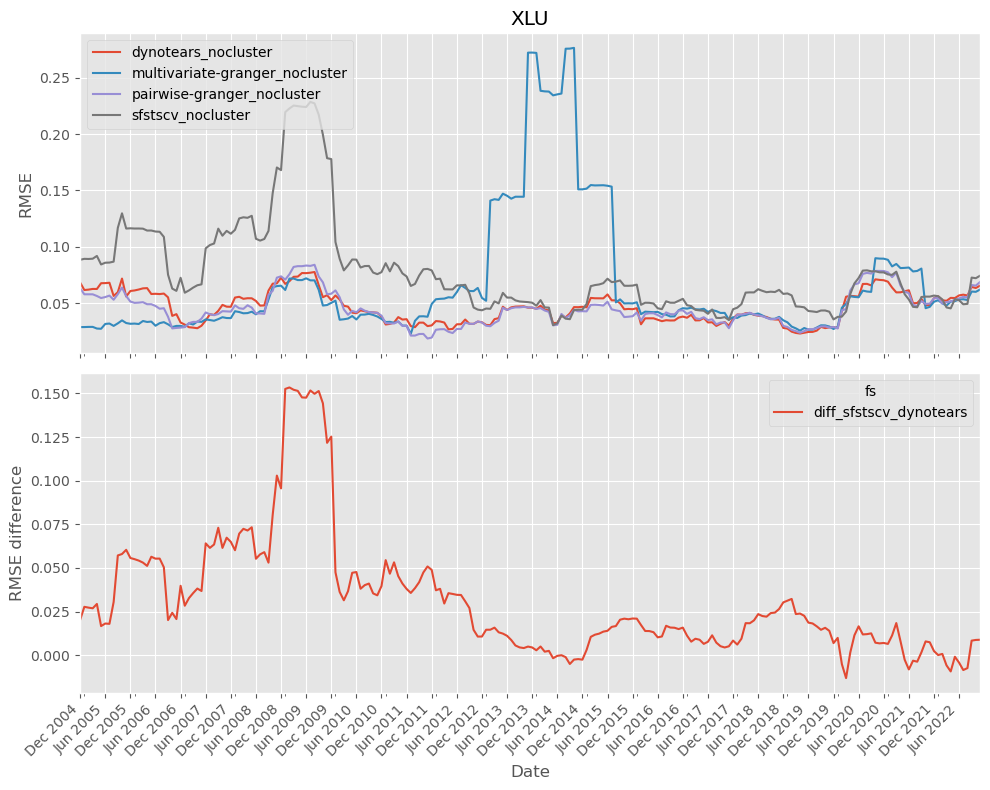

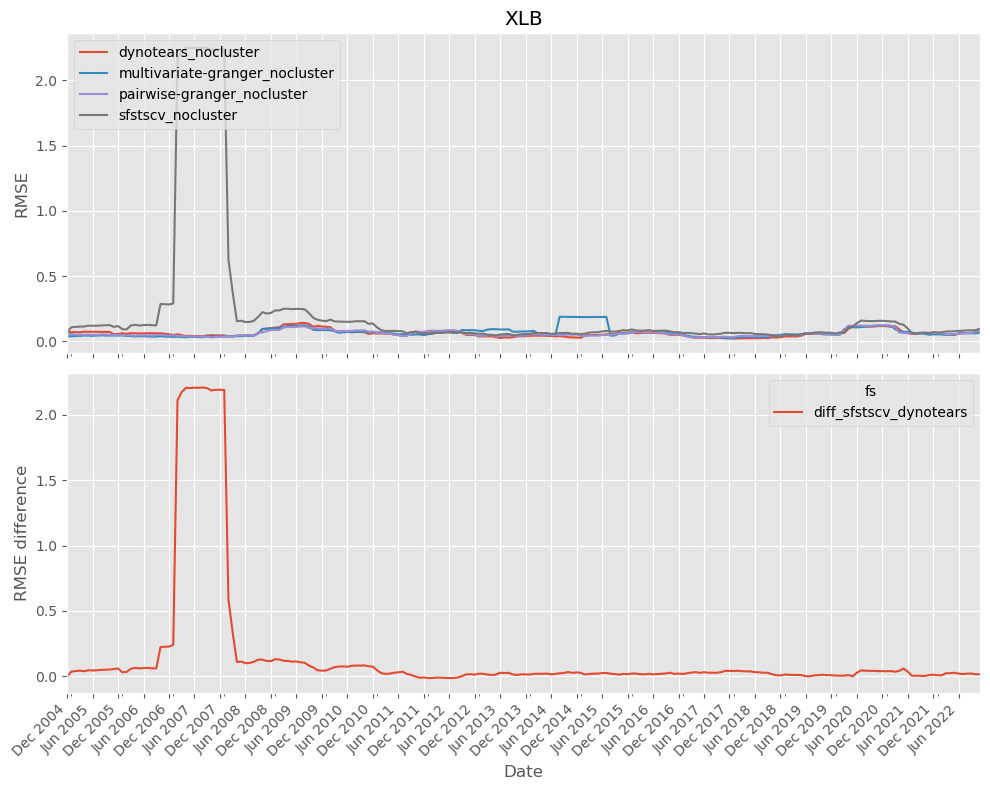

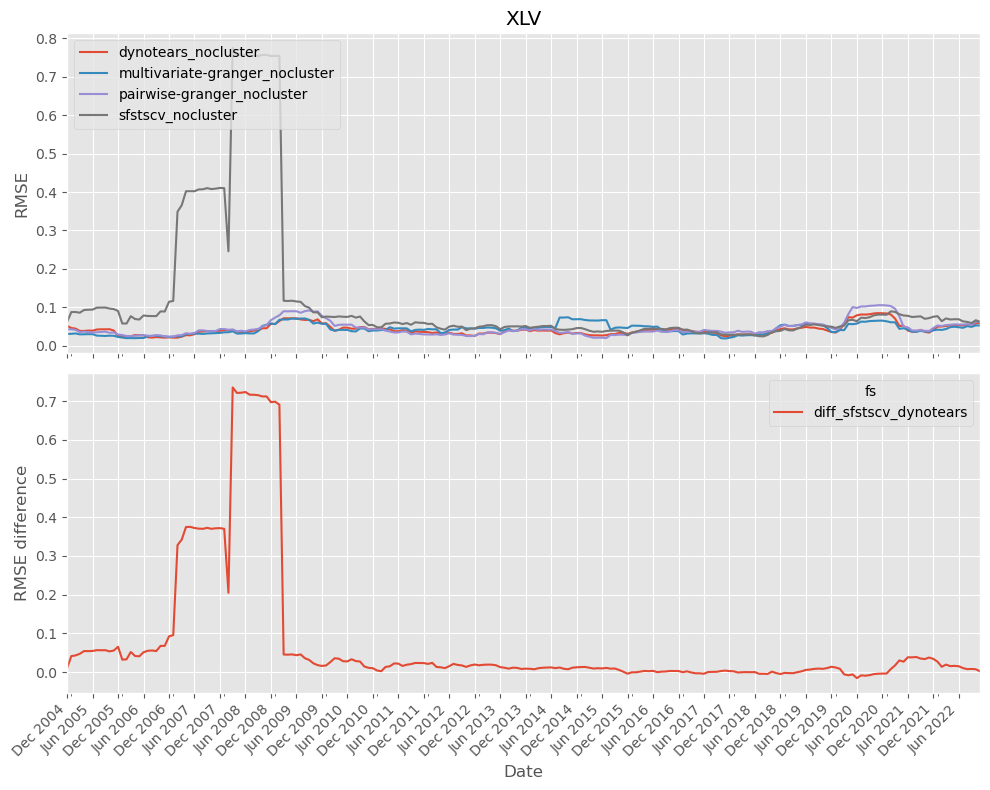

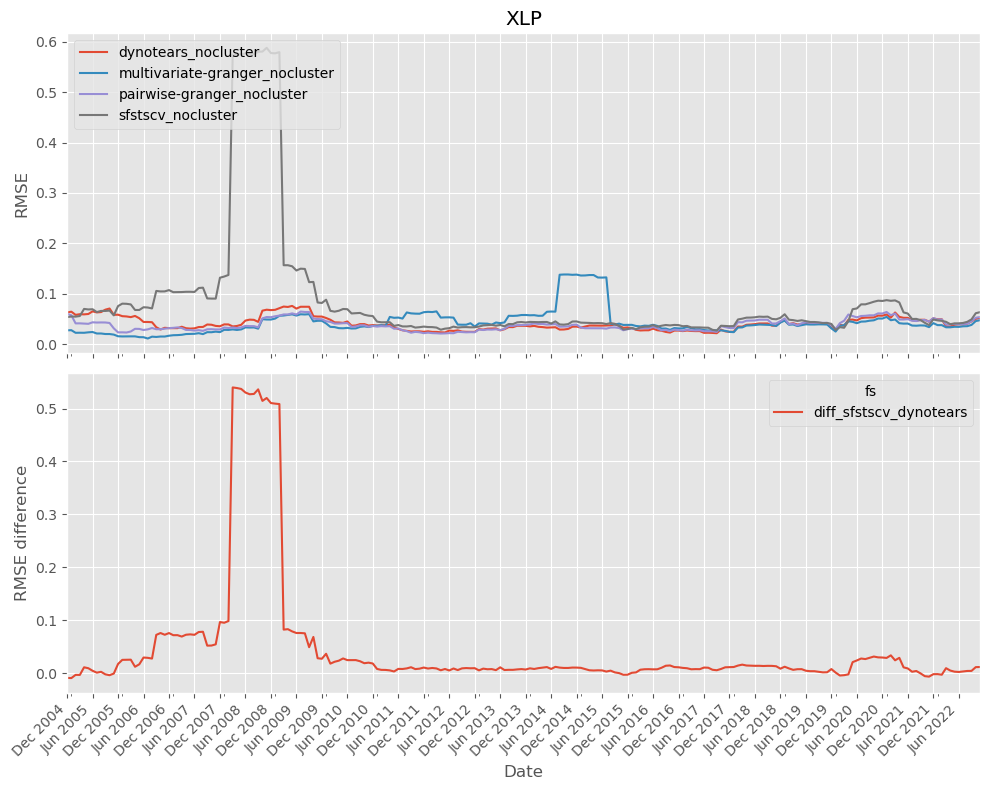

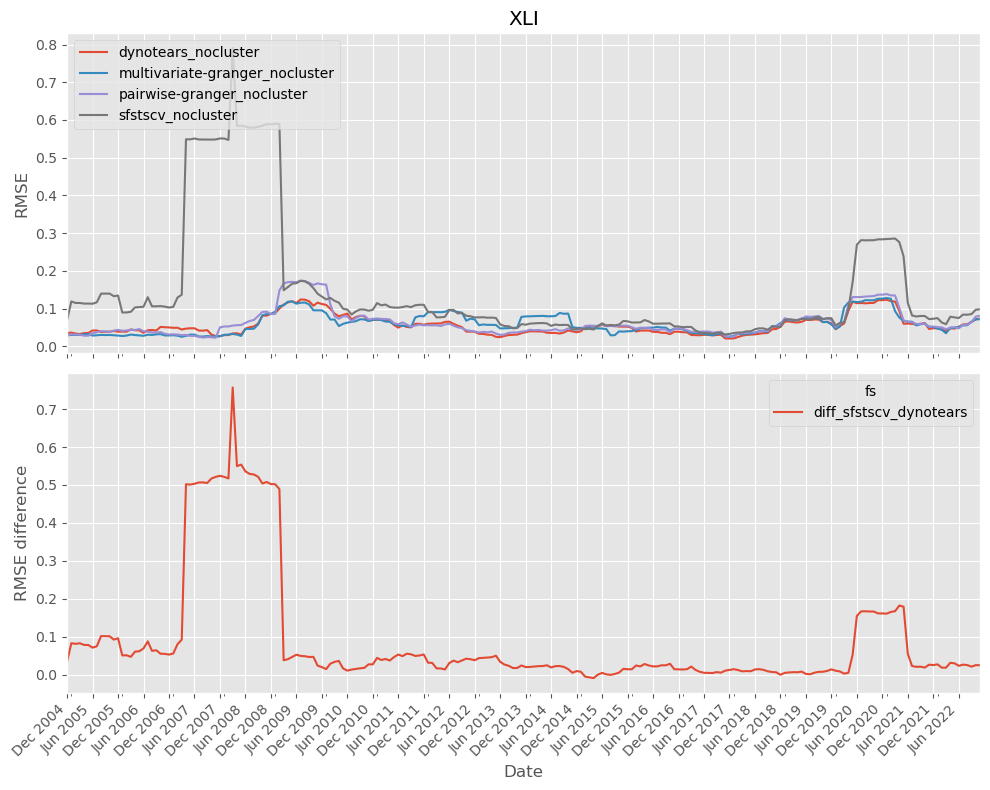

In [64]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
]

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_sfstscv_dynotears"] = etf_rolling_metrics_df["sfstscv_nocluster"] - etf_rolling_metrics_df["dynotears_nocluster"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_sfstscv_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('RMSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_sfstscv_dynotears"]].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('RMSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_rmse.png'))

    # Show the plot
    plt.show()

### (c) Rolling MAE

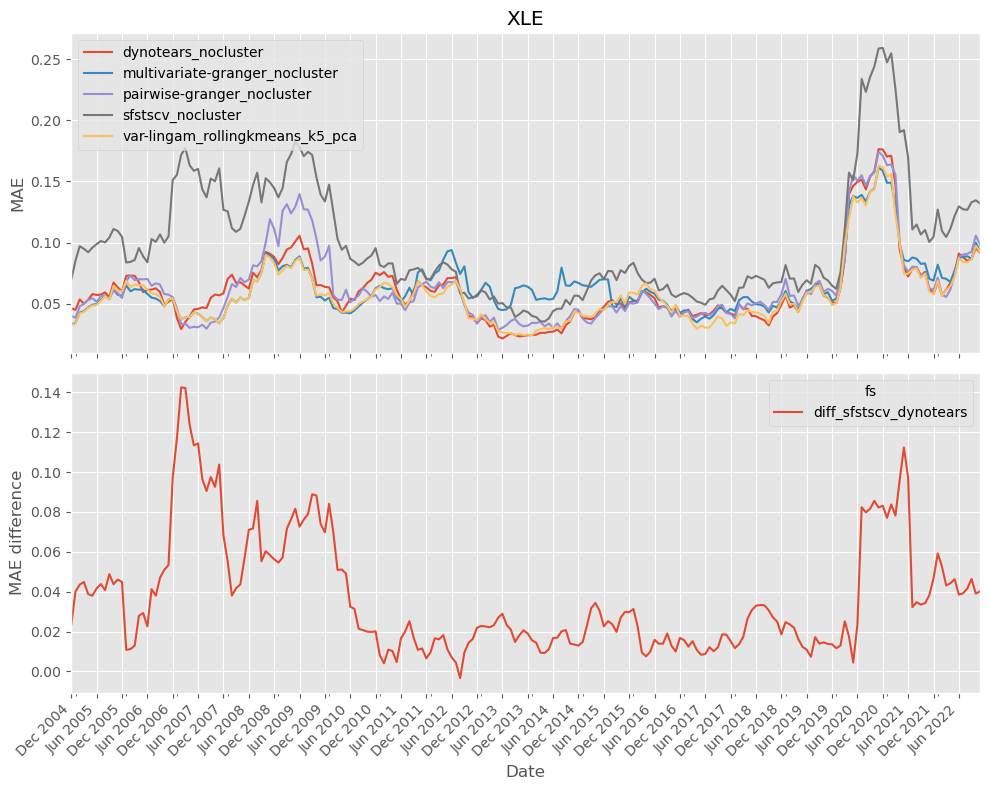

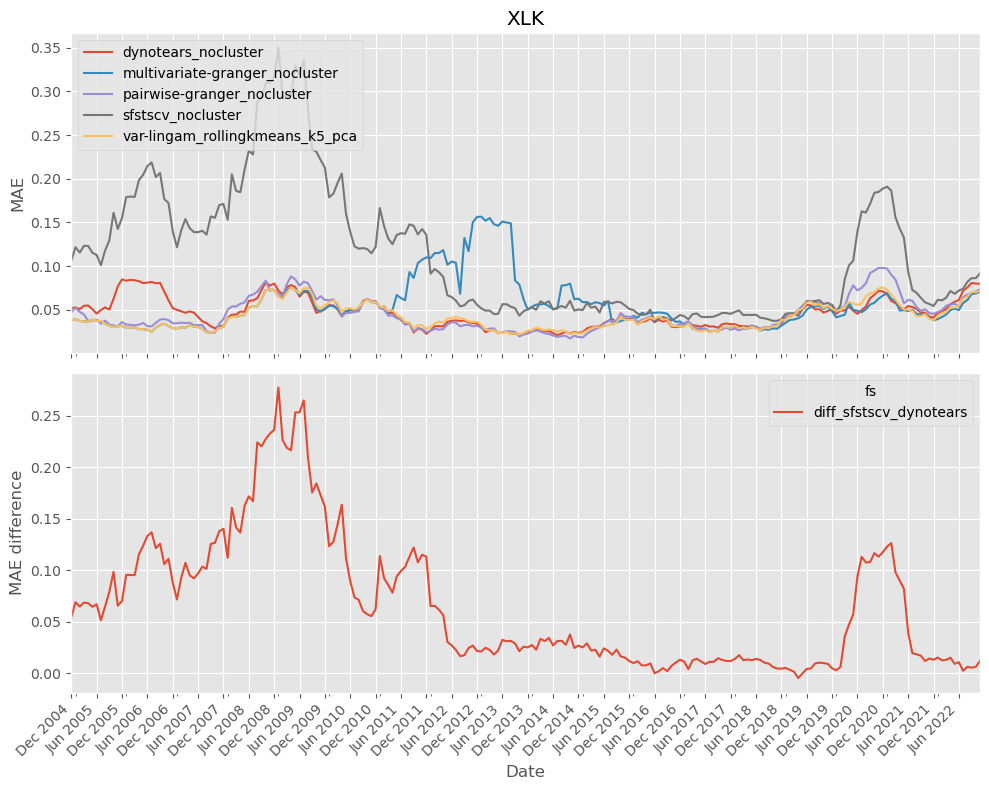

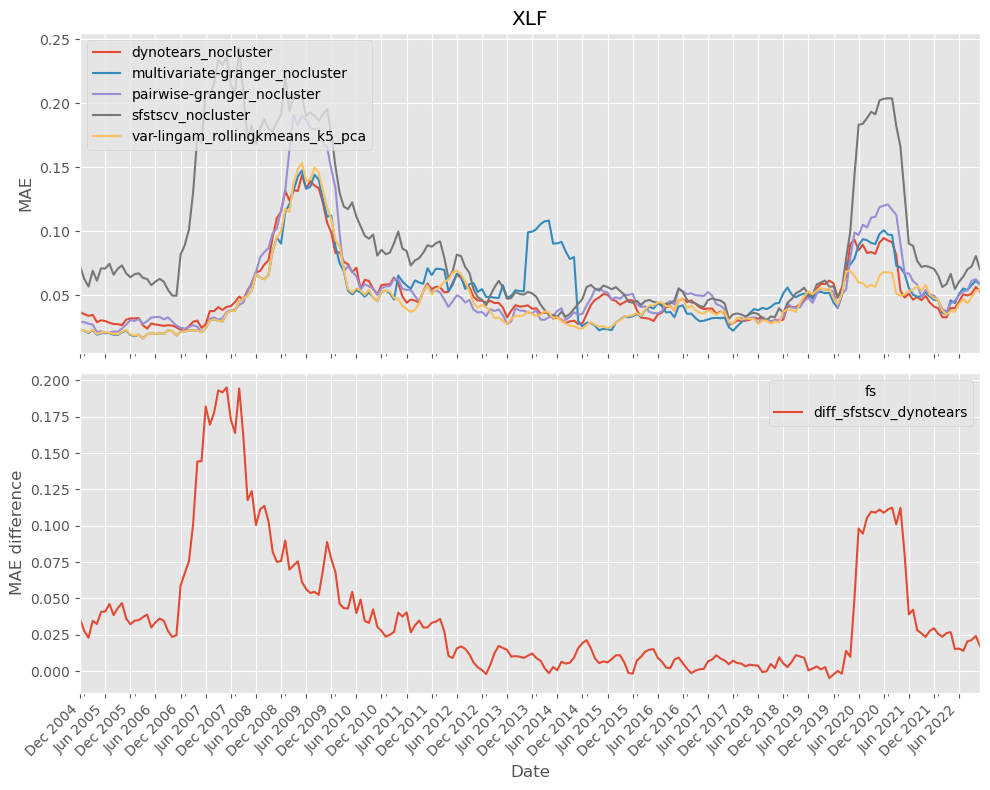

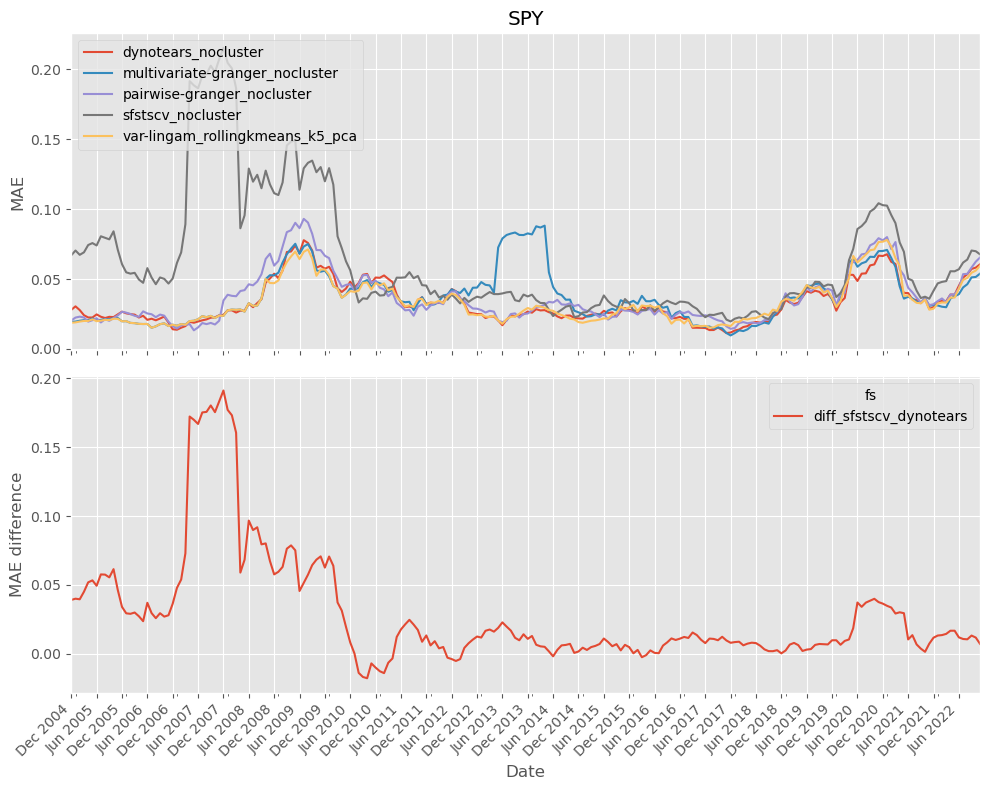

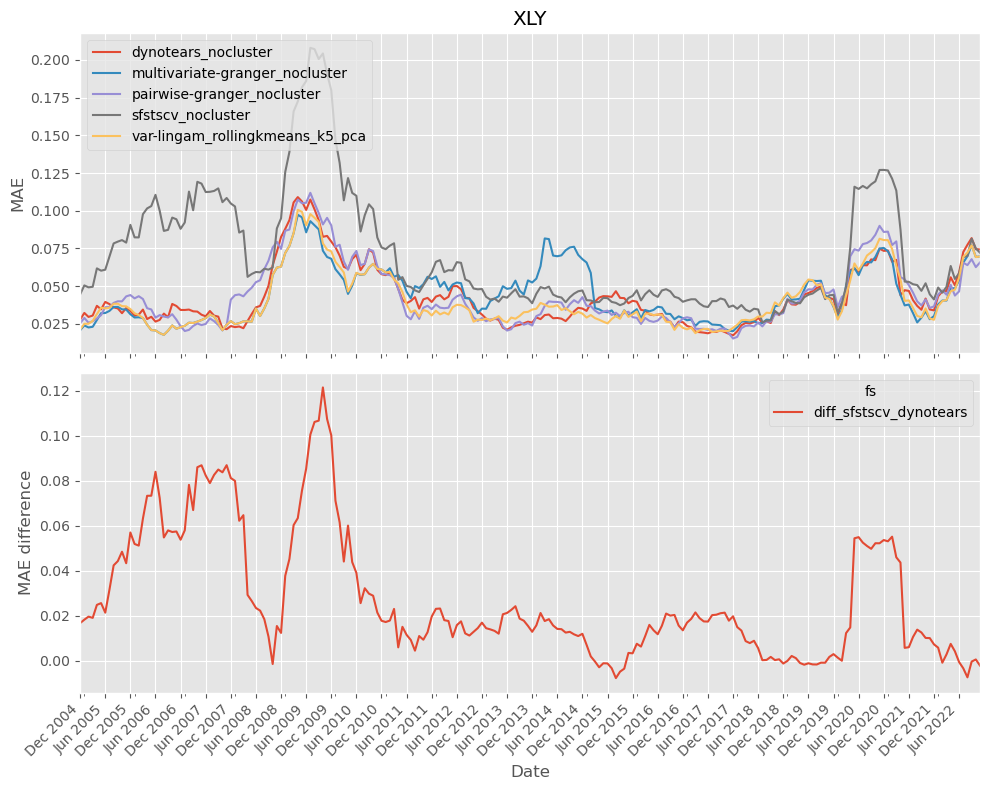

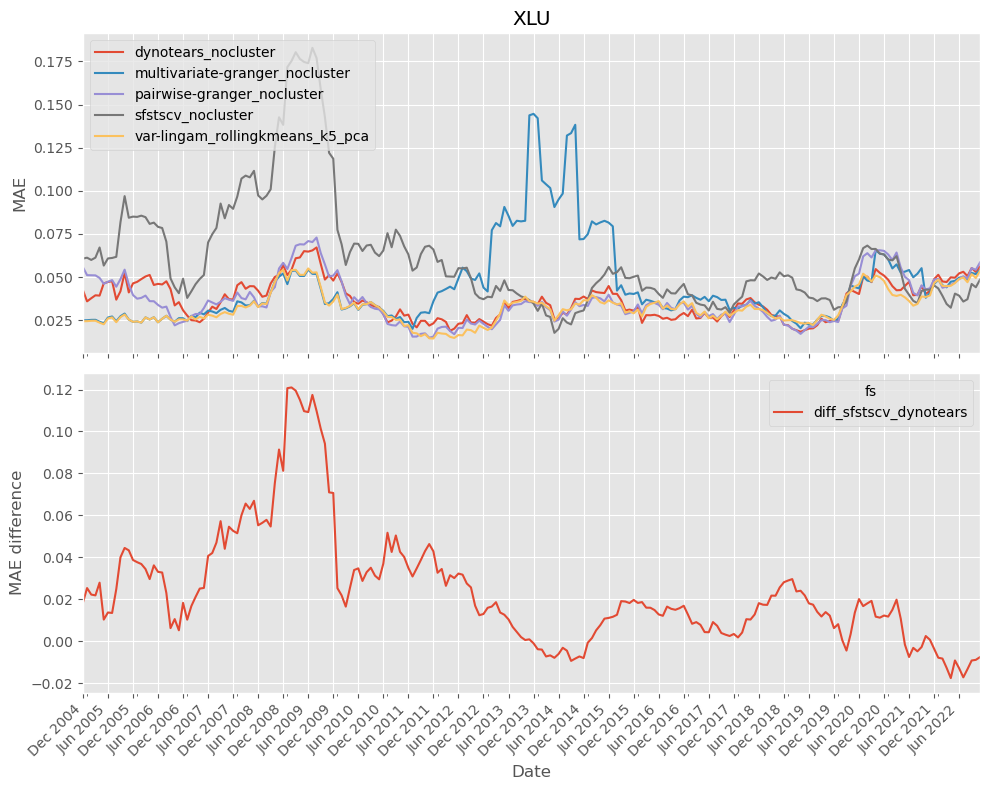

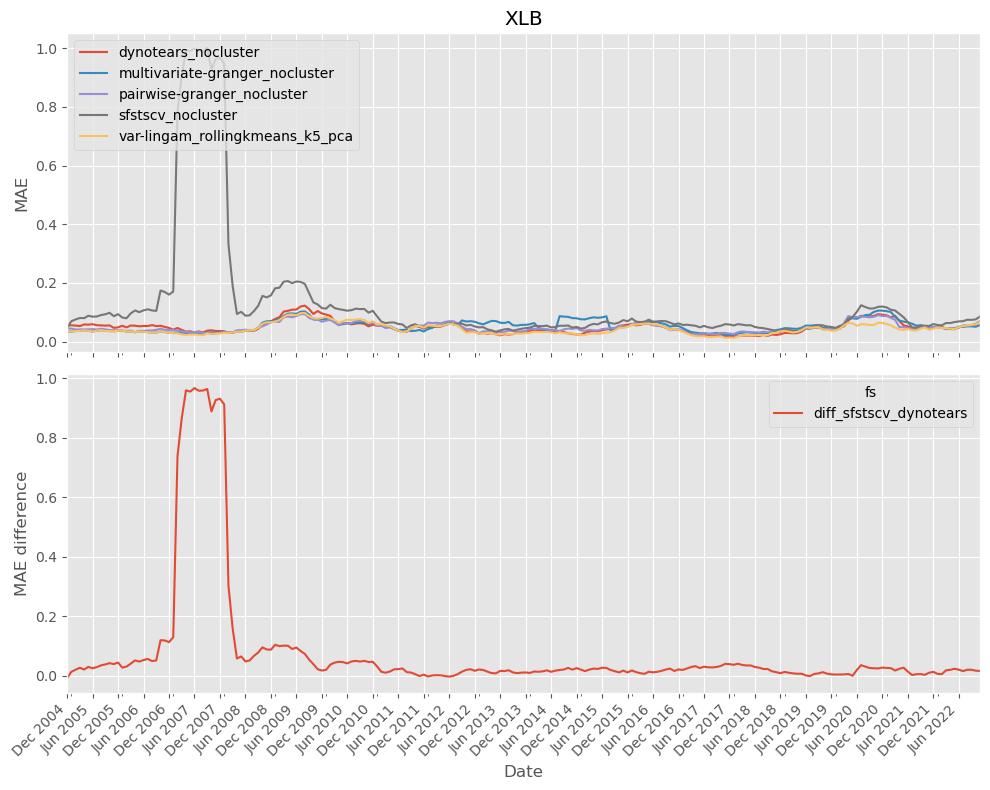

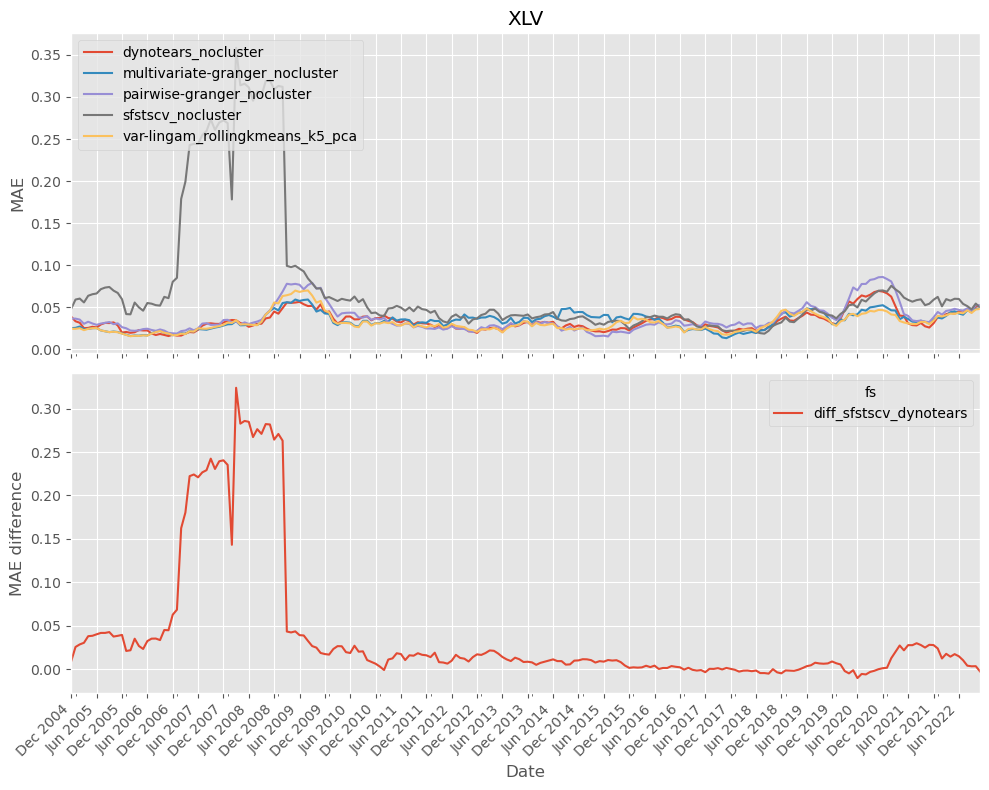

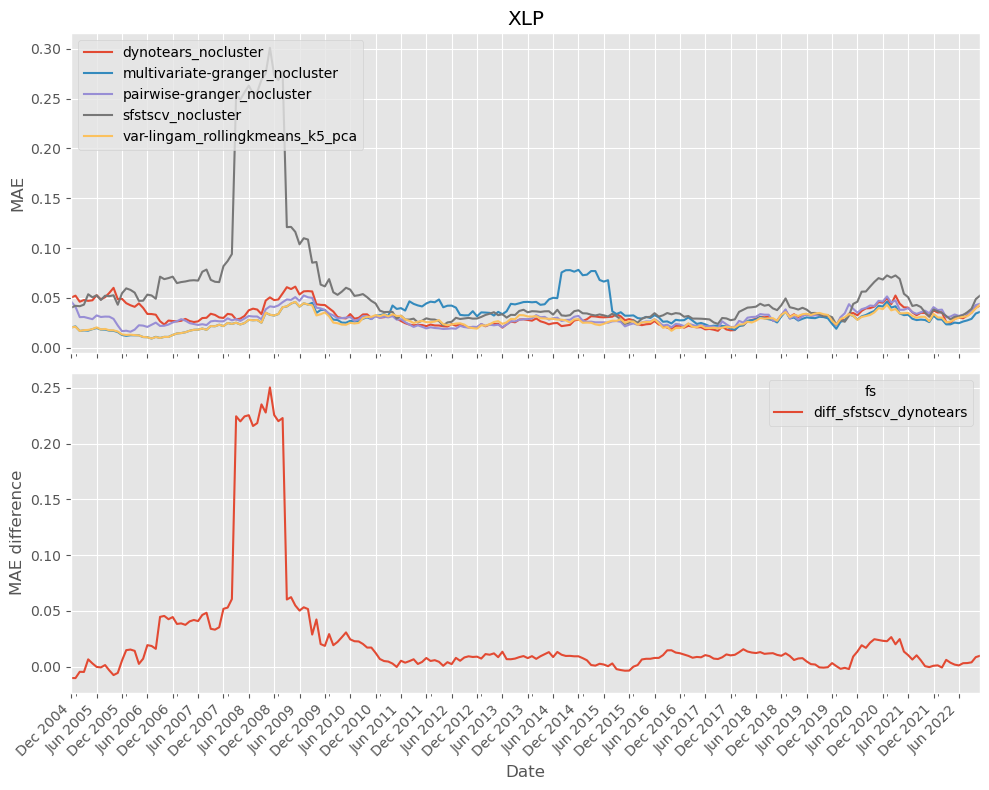

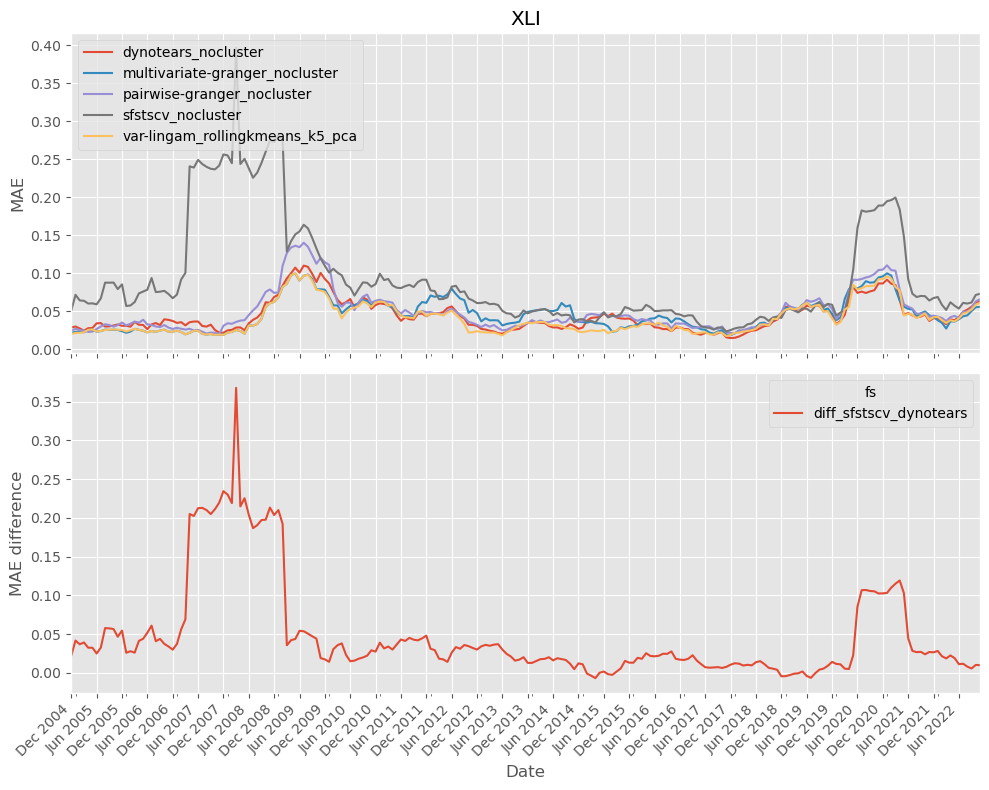

In [67]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
    "var-lingam_rollingkmeans_k5_pca",
]

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mae")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_sfstscv_dynotears"] = etf_rolling_metrics_df["sfstscv_nocluster"] - etf_rolling_metrics_df["dynotears_nocluster"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_sfstscv_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MAE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_sfstscv_dynotears"]].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MAE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mae.png'))

    # Show the plot
    plt.show()

### (b) Bias-Variance Trade-off

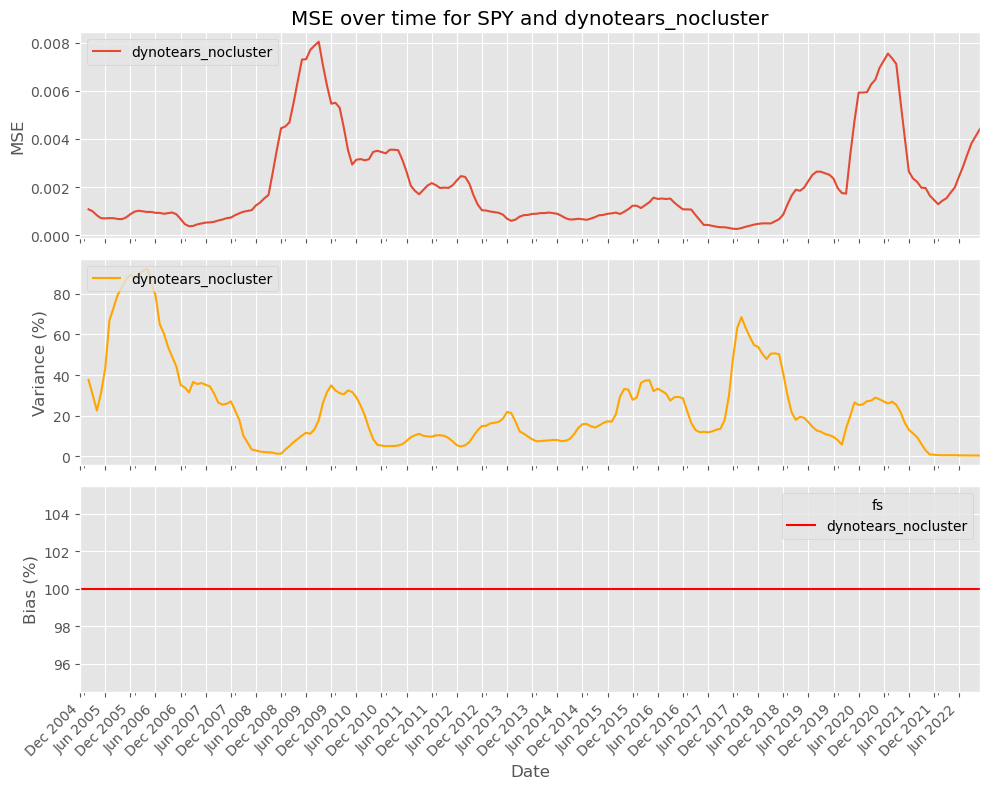

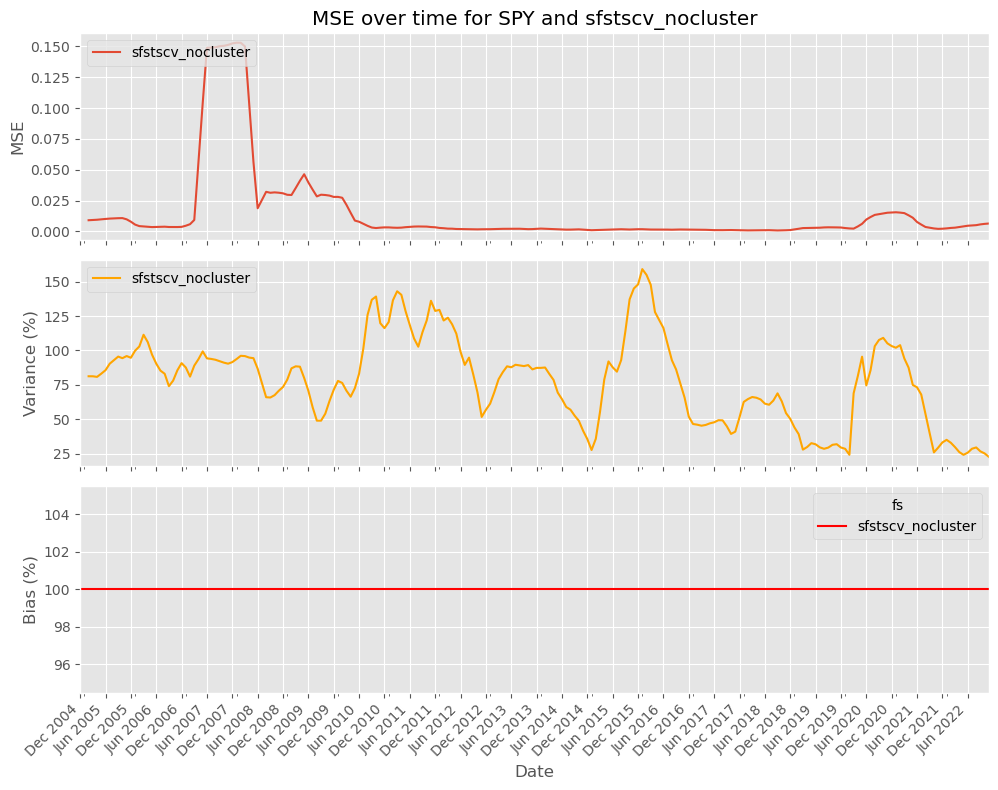

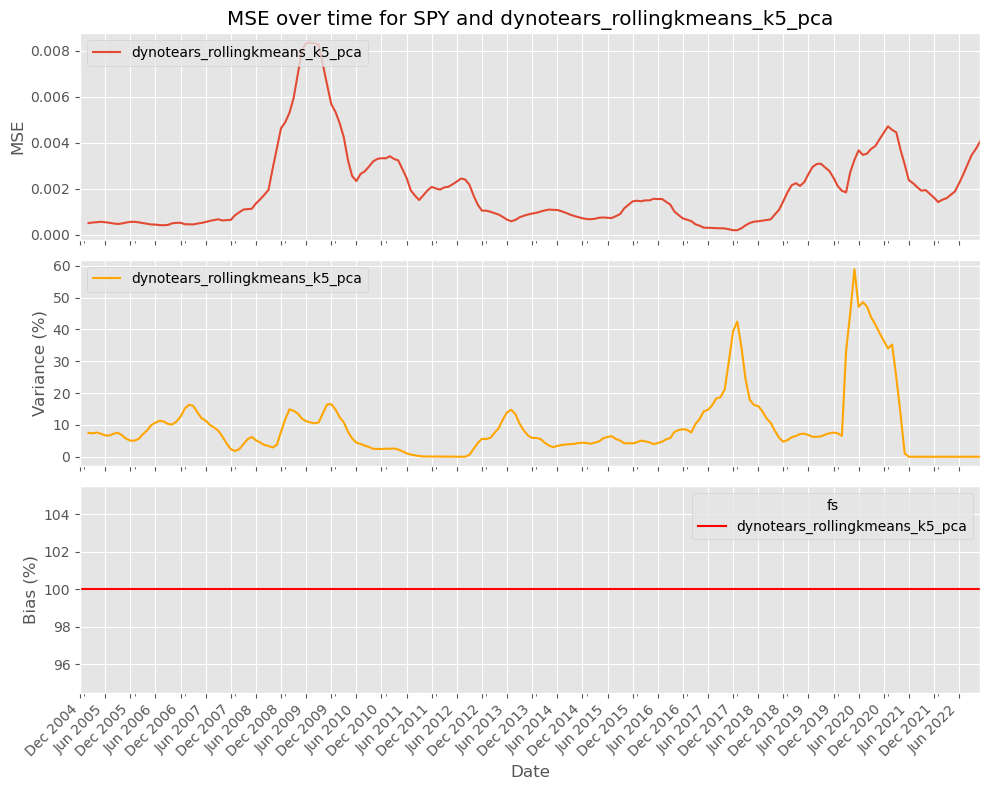

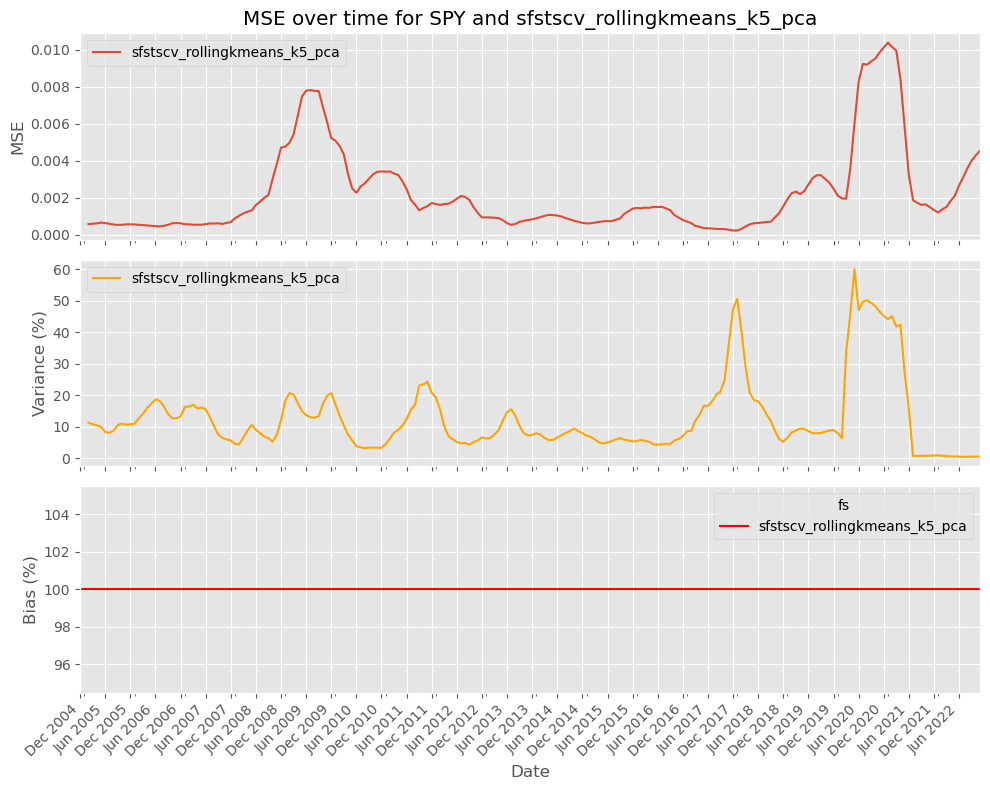

In [38]:
etf = "SPY"
fss = [
    "dynotears_nocluster",
    "sfstscv_nocluster",
    "dynotears_rollingkmeans_k5_pca",
    "sfstscv_rollingkmeans_k5_pca",
]

for fs in fss:
    # mse
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()

    # variance
    etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
    etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
    etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
    etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

    # bias
    etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
    etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
    etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
    etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

    # plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    # plotting on the upper subplot
    etf_rolling_metrics_df.plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf} and {fs}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # plotting on the upper subplot
    etf_rolling_variance_df.plot(ax=axs[1], color="orange")
    # axs[1].set_title(f'Variance over time for {etf}')
    axs[1].set_ylabel('Variance (%)')
    axs[1].legend(loc='upper left')

    # plotting on the lower subplot
    etf_rolling_bias_df.plot(ax=axs[2], color="red")
    # axs[2].set_title(f'Bias over time for {etf}')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Bias (%)')

    # adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[2].set_xticks(tick_positions)
    axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

## Summary Statistics

In [39]:
all_metrics_df.reset_index().groupby("fs").median().sort_values(by="mse", ascending=True)

mse       mae       rmse  \
fs                                                                         
multivariate-granger_rollingkmeans_k5_pca  0.286058  3.982578   5.346146   
dynotears_rollingkmeans_k5_pca             0.286413  3.972322   5.351305   
pairwise-granger_rollingkmeans_k5_pca      0.308596  4.006894   5.555122   
sfstscv_rollingkmeans_k5_pca               0.322608  4.042943   5.679341   
dynotears_nocluster                        0.359220  4.359993   5.993460   
pairwise-granger_nocluster                 0.378489  4.445791   6.151272   
multivariate-granger_nocluster             0.514644  4.514639   7.144028   
sfstscv_nocluster                          2.084035  8.078638  14.434161   

                                           mse_crisis  mae_crisis  rmse_crisis  
fs                                                                              
multivariate-granger_rollingkmeans_k5_pca    0.444492    4.893856     6.655594  
dynotears_rollingkmeans_k5_pca               0.437583    5.098209     6.613885  
pairwise-granger_rollingkmeans_k5_pca        0.478556    5.021904     6.917729  
sfstscv_rollingkmeans_k5_pca                 0.472949    5.088119     6.875909  
dynotears_nocluster                          0.521264    5.301982     7.200519  
pairwise-granger_nocluster                   0.625687    5.623615     7.887384  
multivariate-granger_nocluster               0.647109    5.737695     8.036423  
sfstscv_nocluster                            3.091421   11.884014    17.563102

In [40]:
all_metrics_df.reset_index().groupby("fs").median().sort_values(by="mse_crisis", ascending=True)

mse       mae       rmse  \
fs                                                                         
dynotears_rollingkmeans_k5_pca             0.286413  3.972322   5.351305   
multivariate-granger_rollingkmeans_k5_pca  0.286058  3.982578   5.346146   
sfstscv_rollingkmeans_k5_pca               0.322608  4.042943   5.679341   
pairwise-granger_rollingkmeans_k5_pca      0.308596  4.006894   5.555122   
dynotears_nocluster                        0.359220  4.359993   5.993460   
pairwise-granger_nocluster                 0.378489  4.445791   6.151272   
multivariate-granger_nocluster             0.514644  4.514639   7.144028   
sfstscv_nocluster                          2.084035  8.078638  14.434161   

                                           mse_crisis  mae_crisis  rmse_crisis  
fs                                                                              
dynotears_rollingkmeans_k5_pca               0.437583    5.098209     6.613885  
multivariate-granger_rollingkmeans_k5_pca    0.444492    4.893856     6.655594  
sfstscv_rollingkmeans_k5_pca                 0.472949    5.088119     6.875909  
pairwise-granger_rollingkmeans_k5_pca        0.478556    5.021904     6.917729  
dynotears_nocluster                          0.521264    5.301982     7.200519  
pairwise-granger_nocluster                   0.625687    5.623615     7.887384  
multivariate-granger_nocluster               0.647109    5.737695     8.036423  
sfstscv_nocluster                            3.091421   11.884014    17.563102

## Stability Measures

In [55]:
# fred_data = pd.read_csv(os.path.join(os.getcwd(), "data", "inputs", "fredmd_raw.csv"))

# fred_data[['date', 'CUSR0000SAS', 'DPCERA3M086SBEA', 'IPCONGD']].set_index("date").pct_change(12).to_csv(os.path.join(results_path, "SPY_selected_features_YoY.csv"))

In [44]:
etf = "SPY"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).loc["2006-01-01":"2008-01-01"].dropna(axis=1, how="all").sum(axis=0).sort_values(ascending=False)

       fred           
value  CUSR0000SAS        24.0
       DPCERA3M086SBEA    24.0
       IPCONGD            24.0
       SPY                24.0
       CES2000000008      17.0
       AMDMUOx            16.0
       CES0600000008       9.0
       REALLN              9.0
       CP3Mx               8.0
       M1SL                4.0
       BUSLOANS            1.0
       COMPAPFFx           1.0
       DDURRG3M086SBEA     1.0
       IPB51222S           1.0
       OILPRICEx           1.0
       UEMP27OV            1.0
dtype: float64

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

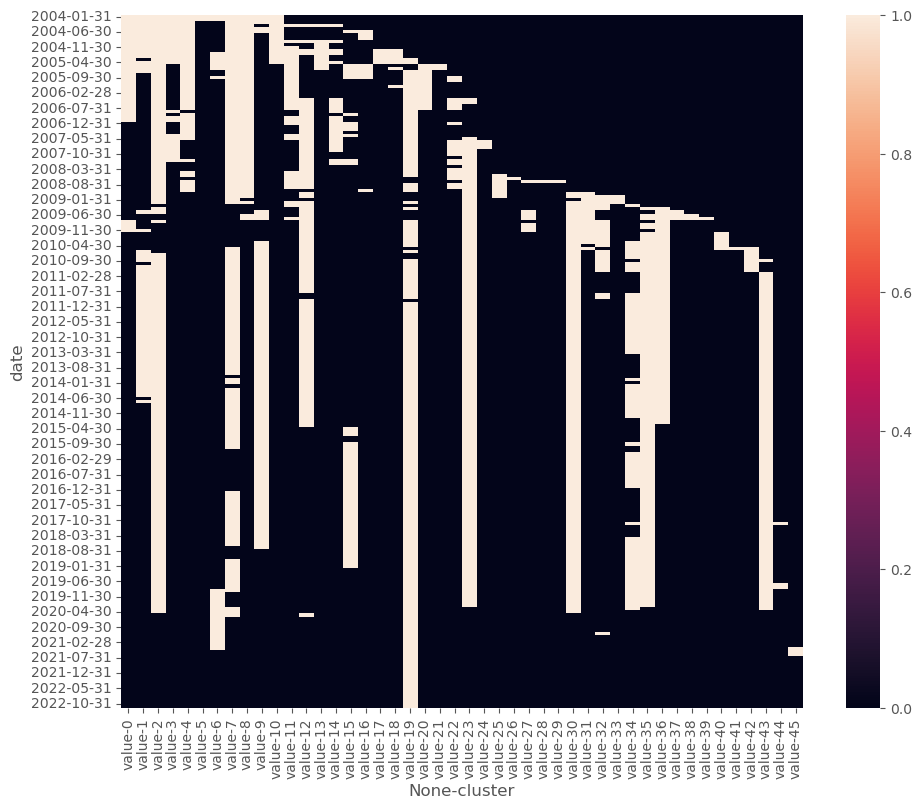

In [46]:
etf = "XLI"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(11, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

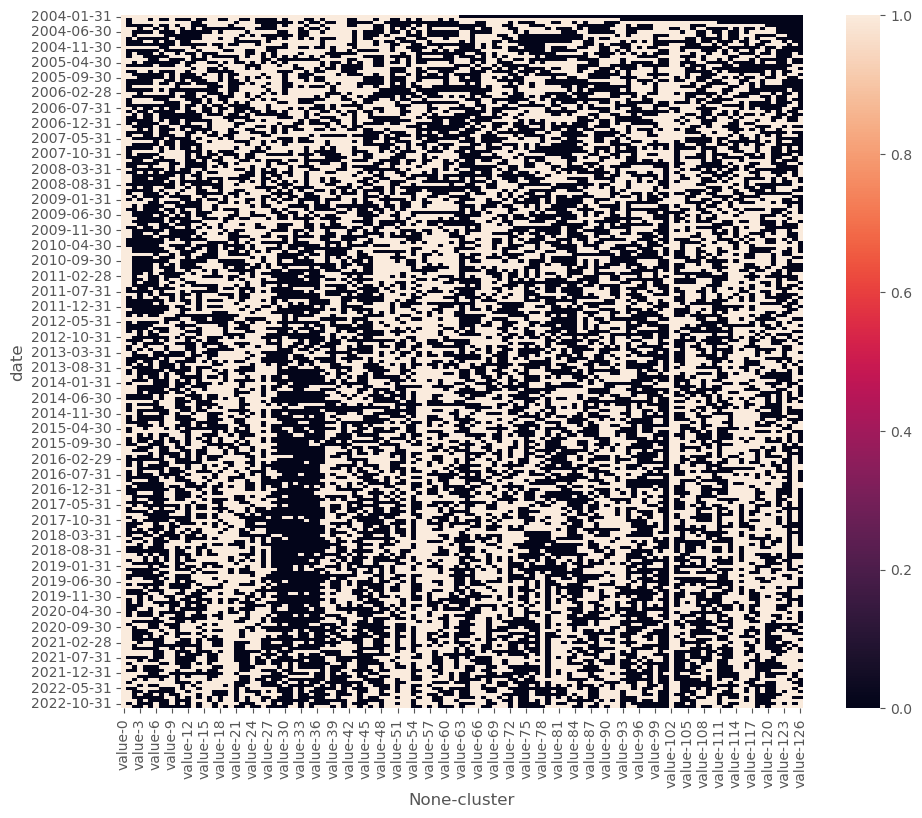

In [47]:
etf = "SPY"
fs = "sfstscv_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(11, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

In [53]:
# pivot_all_etfs_scores_df.reset_index().to_csv(os.path.join(results_path, "stability_df.csv"), index=False)

<AxesSubplot:xlabel='date'>

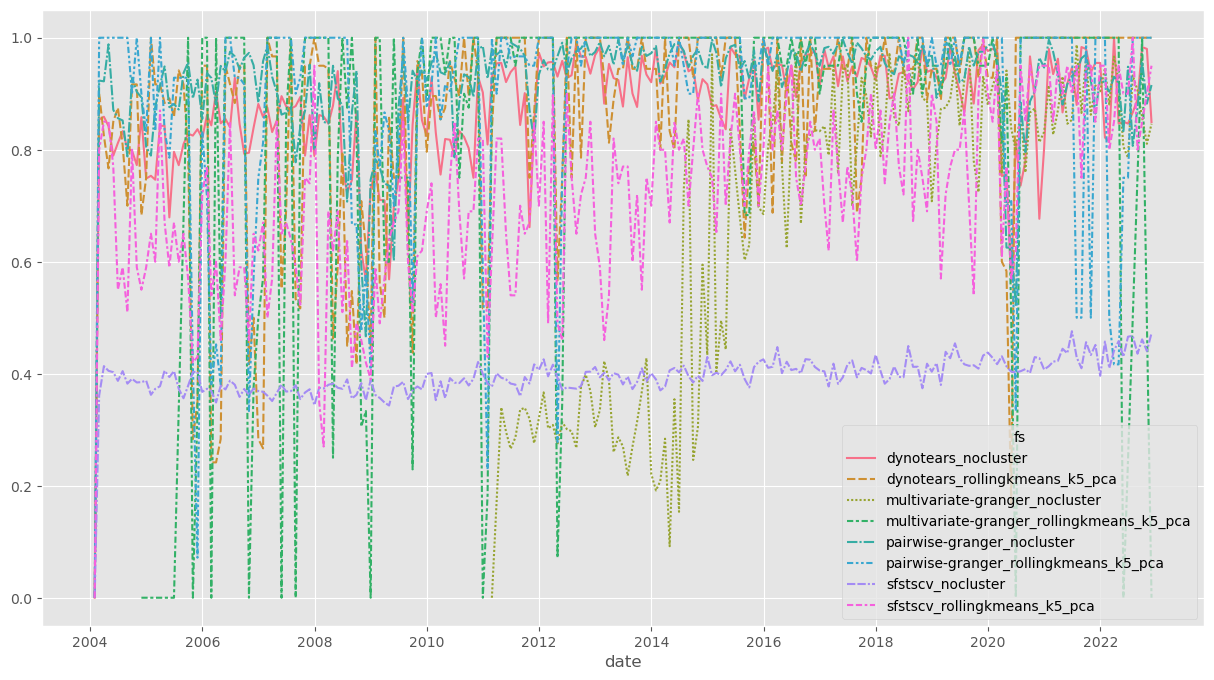

In [48]:
pivot_all_etfs_scores_df = all_etfs_scores_df.pivot_table(index=["date"], columns=["fs"], values=["value"])
pivot_all_etfs_scores_df.columns = pivot_all_etfs_scores_df.columns.droplevel(0)
pivot_all_etfs_scores_df.index = pd.to_datetime(pivot_all_etfs_scores_df.index)

plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_all_etfs_scores_df)

<AxesSubplot:xlabel='date'>

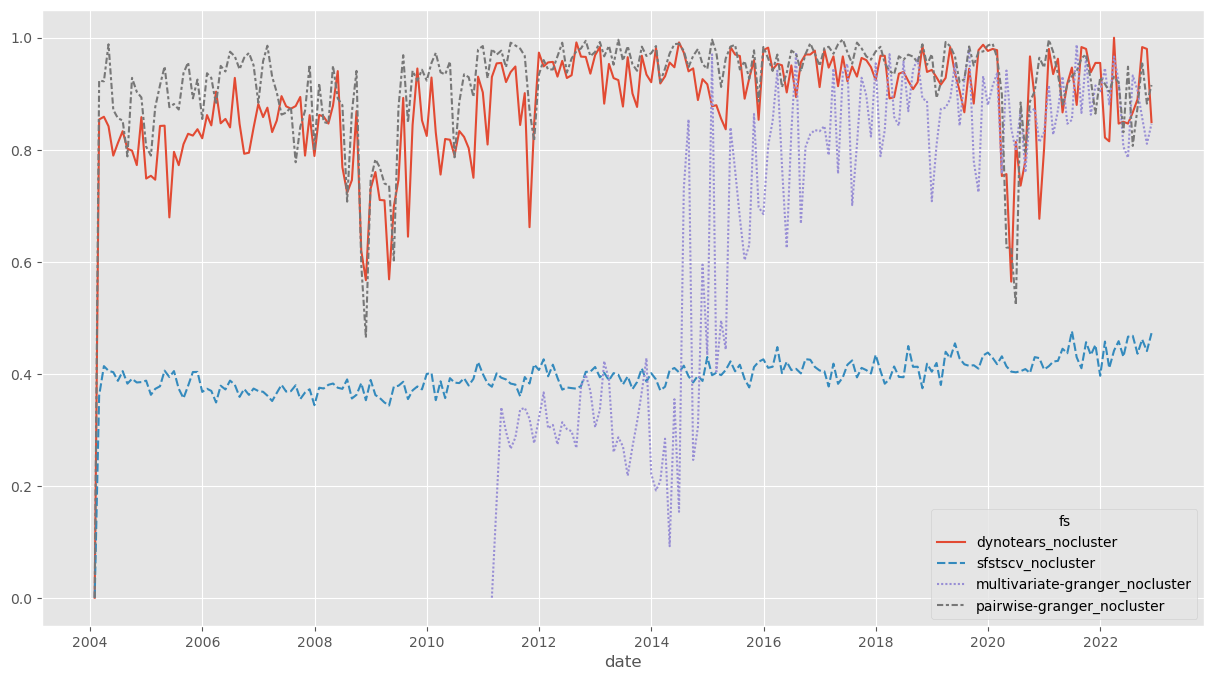

In [30]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_all_etfs_scores_df[["dynotears_nocluster", "sfstscv_nocluster", "multivariate-granger_nocluster", "pairwise-granger_nocluster"]])